In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import random
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import keras
import tensorflow as tf

import ast

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 150

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
df = pd.read_csv('flat_df_no_nulli_no_out.csv', index_col=0)

In [3]:
features = [
 'chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_bandwidthmean01',
 'spectral_bandwidthmedian01',
 'spectral_bandwidthmin01',
 'spectral_bandwidthskew01',
 'spectral_bandwidthstd01',
 'spectral_centroidkurtosis01',
 'spectral_centroidmax01',
 'spectral_centroidmean01',
 'spectral_centroidmedian01',
 'spectral_centroidmin01',
 'spectral_centroidskew01',
 'spectral_centroidstd01',
 'spectral_rolloffkurtosis01',
 'spectral_rolloffmax01',
 'spectral_rolloffmean01',
 'spectral_rolloffmedian01',
 'spectral_rolloffmin01',
 'spectral_rolloffskew01',
 'spectral_rolloffstd01',
 'zcrkurtosis01',
 'zcrmax01',
 'zcrmean01',
 'zcrmedian01',
 'zcrmin01',
 'zcrskew01',
 'zcrstd01',
]


bitmap = [
    'Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken',
]

nulli = [
     'ALBUM_date_released_year',
    'ALBUM_favorites',
     'ALBUM_listens',
 'ALBUM_tracks',
 'ALBUM_type',
 'ARTIST_favorites',
 'ARTIST_location',
 'TRACK_favorites',
  'ARTIST_location_',
    'TRACK_genres_soloTop'
]

nonNumerici = [
    'ALBUM_tags',
    'ALBUM_title',
    'ARTIST_location_',
    'ARTIST_name',
    'ARTIST_tags',
    'SET_subset',
    'TRACK_genre_top',
    'TRACK_genres',
    'TRACK_genres_all',
    'TRACK_genres_soloTop',
    'TRACK_tags',
    'TRACK_title',
    'TRACK_genres_soloTop'
]

In [4]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli)

compl.sort()

compl

['ALBUM_date_released_year_',
 'ALBUM_favorites_',
 'ALBUM_listens_',
 'ALBUM_tracks_',
 'ALBUM_type_',
 'ARTIST_favorites_',
 'TRACK_bitrate',
 'TRACK_duration',
 'TRACK_interest',
 'TRACK_listens',
 'TRACK_number']

In [5]:
df[bitmap] = df[bitmap].fillna(value=0)

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [111]:
attributes = list()
corr = df[features].corrwith(other=df["TRACK_duration"])


for i in range(0, len(corr)):
    key = corr.keys()[i]
    value = corr[i]
    if (abs(value) > .0) & (key != 'TRACK_duration'):
        attributes.append(key)
    #print(key, "   ", abs(value))
    
attributes

['chroma_censkurtosis',
 'chroma_censmax',
 'chroma_censmean',
 'chroma_censmedian',
 'chroma_censmin',
 'chroma_censskew',
 'chroma_censstd',
 'chroma_censcqtkurtosis',
 'chroma_cqtmax',
 'chroma_cqtmean',
 'chroma_cqtmedian',
 'chroma_cqtmin',
 'chroma_cqtskew',
 'chroma_cqtstd',
 'chroma_stftkurtosis',
 'chroma_stftmax',
 'chroma_stftmean',
 'chroma_stftmedian',
 'chroma_stftmin',
 'chroma_stftskew',
 'chroma_stftstd',
 'mfcckurtosis',
 'mfccmax',
 'mfccmean',
 'mfccmedian',
 'mfccmin',
 'mfccskew',
 'mfccstd',
 'spectral_contrastkurtosis',
 'spectral_contrastmax',
 'spectral_contrastmean',
 'spectral_contrastmedian',
 'spectral_contrastmin',
 'spectral_contrastskew',
 'spectral_contraststd',
 'tonnetzkurtosis',
 'tonnetzmax',
 'tonnetzmean',
 'tonnetzmedian',
 'tonnetzmin',
 'tonnetzskew',
 'tonnetzstd',
 'rmsekurtosis01',
 'rmsemax01',
 'rmsemean01',
 'rmsemedian01',
 'rmsemin01',
 'rmseskew01',
 'rmsestd01',
 'spectral_bandwidthkurtosis01',
 'spectral_bandwidthmax01',
 'spectral_

In [112]:
df.corrwith(other=df["TRACK_duration"])[1]

-0.06790008763235142

In [113]:
def stampa(reg, X_test, y_test):
    y_pred = reg.predict(X_test)
    #print('Coefficients: \n', reg.coef_)
    print('Intercept: \n', reg.intercept_)
    print('R2: %.3f' % r2_score(y_test, y_pred))
    print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
    print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

In [114]:
X = df[attributes+bitmap].values
y = df["TRACK_duration"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)


linear = LinearRegression()
lasso = Lasso(alpha=.016, max_iter=10000)
ridge = Ridge(alpha=1.231)


linear.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

print("LINEAR")
stampa(linear, X_test, y_test)

print("\n\n\nLASSO")
stampa(lasso, X_test, y_test)

print("\n\n\nRIDGE")
stampa(ridge, X_test, y_test)

LINEAR
Intercept: 
 210.62528212007769
R2: 0.331
MSE: 51057.601
MAE: 121.302



LASSO
Intercept: 
 207.21999667278376
R2: 0.331
MSE: 51072.053
MAE: 121.147



RIDGE
Intercept: 
 208.88457287001964
R2: 0.331
MSE: 51065.774
MAE: 121.135


C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76708075.91391706, tolerance: 500998.88782823563
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68154322.1781807, tolerance: 500998.88782823563
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47270699.48843479, tolerance: 500998.88782823563
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: 

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92090446.18605185, tolerance: 498942.1600514683
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1091567.4378376007, tolerance: 474244.0011640367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37179835.40146923, tolerance: 474244.0011640367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: C

C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133209198.01328754, tolerance: 484055.37649754545
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70419784.94842052, tolerance: 484055.37649754545
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140989165.9842415, tolerance: 484055.37649754545
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\cri98\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525

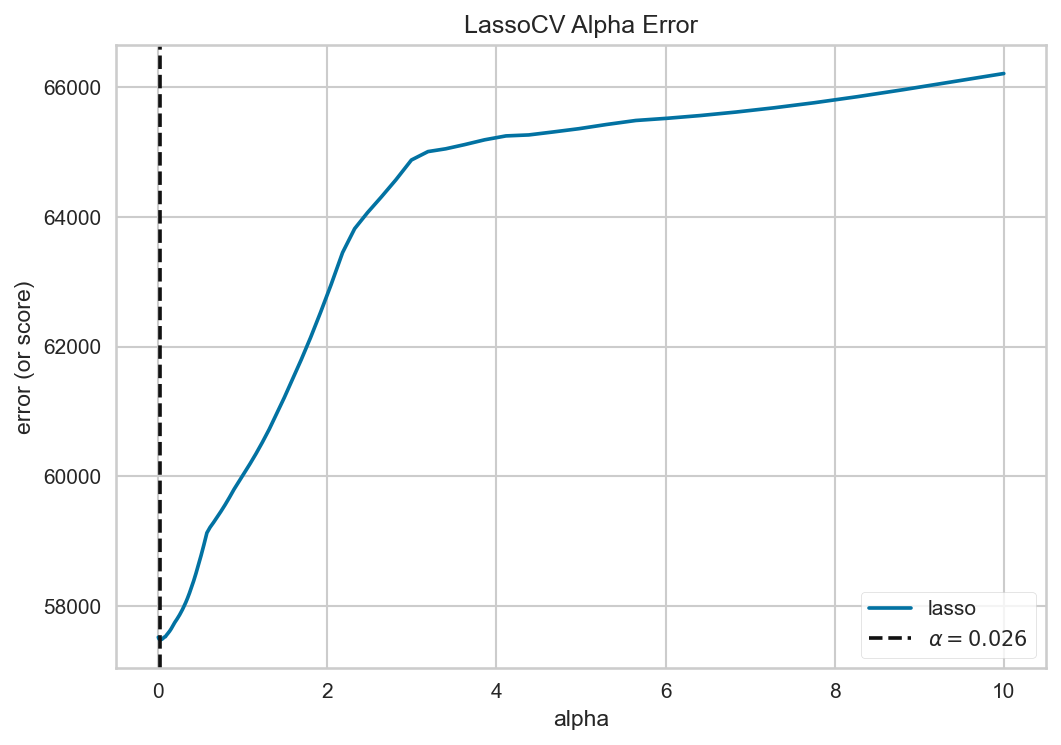

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [117]:
from sklearn.linear_model import LassoCV, RidgeCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection



alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, max_iter=10000)
visualizer = AlphaSelection(model)
visualizer.fit(X_train, y_train)
plt.savefig("LassoMulti.pdf", bbox_inches="tight")
visualizer.show()

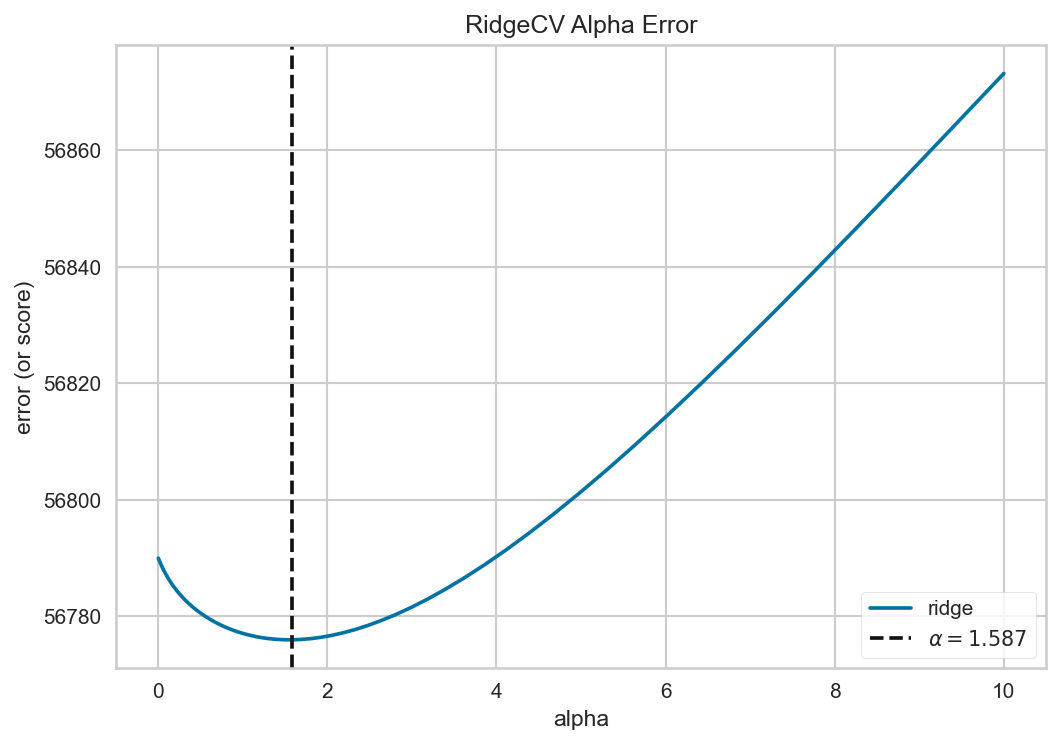

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [118]:
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train, y_train)
plt.savefig("RidgeMulti.pdf", bbox_inches="tight")
visualizer.show()

In [93]:
from sklearn.svm import SVR

In [ ]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_lin.fit(X_train, y_train)

print("LINEAR")
stampa(svr_lin, X_test, y_test)

In [34]:
indiciDaDroppare = list()

for i in tqdm(df.index):
    if df[df.index == i].TRACK_duration.iloc[0] not in valori_durata_ok:
        indiciDaDroppare.append(i)
        

len(indiciDaDroppare)

1070

In [11]:
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [104]:
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl


bitmaps = {}
bitmaps[0] = pd.get_dummies(df["ALBUM_date_released_year_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[1] = pd.get_dummies(df["ALBUM_tracks_"].apply(pd.Series).stack()).sum(level=0)

bitmaps[2] = pd.get_dummies(df["ALBUM_type_"].apply(pd.Series).stack()).sum(level=0)
bitmaps[3] = pd.get_dummies(df["TRACK_bitrate"].apply(pd.Series).stack()).sum(level=0)


for i in range(4):
    df = pd.concat([df, bitmaps[i]], axis=1)

    
df.drop(columns=["ALBUM_date_released_year_", 'ALBUM_tracks_', 'ALBUM_type_', 'TRACK_bitrate'], inplace=True)

df


#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])

compl



featuresdf = pd.read_csv('fma_metadata_progetto/features.csv', index_col=0, header=[0, 1, 2])

flat_features = pd.DataFrame()

for l1 in featuresdf.columns:
    name = ""
    for l2 in l1:
        name = name + l2
        
    flat_features[name] = featuresdf[l1]
    
df = pd.merge(df, flat_features, left_index=True, right_index=True)

df



#Ricalcolo compl
def Diff(li1, li2):
    return list(set(li1)-set(li2))

tutti = list(df.columns)

compl = Diff(tutti, features + bitmap + nonNumerici + nulli+ ['target'])


compl

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 31.0,
 39.0,
 40.0,
 38.0,
 41.0,
 42.0,
 44.0,
 43.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 45.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 52.0,
 53.0,
 62.0,
 59.0,
 60.0,
 65.0,
 66.0,
 67.0,
 68.0,
 63.0,
 'spectral_rolloffskew01_x',
 72.0,
 73.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 74.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 93.0,
 92.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139.0,
 140.0,
 141.0,
 142.0,
 1

In [97]:
class_name = 'TRACK_duration'

attributes = Diff(compl + features + bitmap, [class_name]) #Diff(compl + features, ('ALBUM_favorites_', 'ALBUM_listens_', 'TRACK_number', 'TRACK_interest'))
X = df.drop(indiciDaDroppare)[attributes].values
y = df.drop(indiciDaDroppare)[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

#--------------Oversampling:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#ros = RandomOverSampler(random_state=42)
#X_res, y_res = ros.fit_resample(X_train, y_train)


#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)

X_res = X_train
y_res = y_train

#-------------Undersampling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler, StandardScaler

#rus = RandomUnderSampler(random_state=42)
#X_val, y_val = rus.fit_resample(X_val, y_val)



#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()

scaler.fit(X_res)
X_res = scaler.transform(X_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



unique, counts = np.unique(y_train, return_counts=True)
print("train", dict(zip(unique, counts)))

unique, counts = np.unique(y_res, return_counts=True)
print("bilanciato", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("validation", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("test", dict(zip(unique, counts)))


#Trasformo la target value in vettore con 1 sulla posizione del genere giusto
y_res = tf.keras.utils.to_categorical(y_res, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

train {0: 12, 1: 3, 2: 8, 3: 23, 4: 37, 5: 32, 6: 45, 7: 63, 8: 147, 9: 45, 10: 53, 11: 44, 12: 45, 13: 71, 14: 125, 15: 166, 16: 43, 17: 51, 18: 54, 19: 42, 20: 49, 21: 52, 22: 48, 23: 56, 24: 56, 25: 50, 26: 52, 27: 41, 28: 56, 29: 61, 30: 79, 31: 75, 32: 85, 33: 68, 34: 61, 35: 61, 36: 64, 37: 82, 38: 64, 39: 60, 40: 68, 41: 77, 42: 71, 43: 78, 44: 90, 45: 103, 46: 70, 47: 74, 48: 85, 49: 75, 50: 87, 51: 76, 52: 91, 53: 97, 54: 94, 55: 107, 56: 87, 57: 84, 58: 98, 59: 116, 60: 406, 61: 132, 62: 106, 63: 136, 64: 172, 65: 121, 66: 127, 67: 96, 68: 130, 69: 100, 70: 130, 71: 109, 72: 138, 73: 116, 74: 125, 75: 122, 76: 138, 77: 119, 78: 115, 79: 115, 80: 147, 81: 123, 82: 157, 83: 138, 84: 149, 85: 143, 86: 140, 87: 143, 88: 138, 89: 126, 90: 176, 91: 149, 92: 165, 93: 144, 94: 141, 95: 143, 96: 197, 97: 154, 98: 165, 99: 162, 100: 173, 101: 194, 102: 189, 103: 168, 104: 189, 105: 215, 106: 167, 107: 157, 108: 220, 109: 189, 110: 209, 111: 178, 112: 218, 113: 201, 114: 214, 115: 193, 

IndexError: index 176 is out of bounds for axis 1 with size 10

In [98]:
# FUNZIONI PER COSTRUIRE LA NN
def costruisci(n_layer_crescenti=5, initialHiddenLayer=128, n_layer_decrescenti = 5, finalHiddenLayer=128):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    
    for n in range(1, n_layer_crescenti+1):
        model.add(Dense(initialHiddenLayer*(n), activation='relu'))
        print("creo layer crescente di dimensione ", initialHiddenLayer*(n))
    for n in range(n_layer_decrescenti , 0, -1): #CODICE DEI TEST: for n in range(n_layer_decrescenti, 0, -1):
        model.add(Dense(finalHiddenLayer*(n), activation='relu'))
        print("creo layer decrescente di dimensione ", finalHiddenLayer*(n))
        
    model.add(Dense(1))

    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #<-- binario
    model.compile(loss='mean_squared_error', 
                  #metrics=['accuracy'],
                  optimizer='adam', #2
                  #optimizer='adamax' #2
                  #optimizer='nadam' #4
                  #optimizer='adadelta' #177

                 ) #<-- multilabel/multiclass
    
    return model

In [99]:
from pandas.api.types import CategoricalDtype
from collections import Counter
from collections import defaultdict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pandas.api.types import CategoricalDtype
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from tqdm.notebook import tqdm, trange
from collections import defaultdict
from scipy.stats.stats import pearsonr
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

model = costruisci(n_layer_crescenti=1, 
                   initialHiddenLayer=1500,
                      n_layer_decrescenti = 1,
                      finalHiddenLayer=600)

es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)


history1 = model.fit(X_res, y_res, epochs=1000, 
                      #batch_size= 200,
                      #class_weight=class_weight,
                      validation_data=(X_val, y_val), callbacks=[es,mc]
                     ).history

creo layer crescente di dimensione  1500
creo layer decrescente di dimensione  600
Epoch 1/1000
2618/2618 [==============================] - 13s 5ms/step - loss: 33817.4215 - val_loss: 22746.1816
Epoch 2/1000
2618/2618 [==============================] - 10s 4ms/step - loss: 23038.3567 - val_loss: 19961.6875
Epoch 3/1000
2618/2618 [==============================] - 7s 3ms/step - loss: 20971.4521 - val_loss: 19619.7344
Epoch 4/1000
2618/2618 [==============================] - 8s 3ms/step - loss: 18245.1119 - val_loss: 22731.0469
Epoch 5/1000
2618/2618 [==============================] - 8s 3ms/step - loss: 18161.3535 - val_loss: 17756.1504
Epoch 6/1000
2618/2618 [==============================] - 8s 3ms/step - loss: 17542.9431 - val_loss: 17910.8535
Epoch 7/1000
2618/2618 [==============================] - 8s 3ms/step - loss: 16536.5798 - val_loss: 17479.1992
Epoch 8/1000
2618/2618 [==============================] - 8s 3ms/step - loss: 15680.3577 - val_loss: 18439.7930
Epoch 9/1000
2618/2

In [94]:
y_pred = model.predict(X_test)

In [80]:
for i in range(len(y_pred)):
    print(rount(y_pred[i]), " vs ", int(y_test.iloc[i]), " --> ", round(abs(y_pred[i]-int(y_test.iloc[i]))))

[197.33975]  vs  172  -->  [25.339752]
[141.49063]  vs  136  -->  [5.490631]
[135.65805]  vs  138  -->  [-2.3419495]
[272.04565]  vs  366  -->  [-93.954346]
[58.88138]  vs  23  -->  [35.88138]
[213.42497]  vs  273  -->  [-59.575027]
[207.94414]  vs  280  -->  [-72.05586]
[215.15997]  vs  252  -->  [-36.840027]
[301.07782]  vs  220  -->  [81.07782]
[145.39069]  vs  183  -->  [-37.609314]
[353.93326]  vs  514  -->  [-160.06674]
[428.55865]  vs  384  -->  [44.558655]
[286.91885]  vs  143  -->  [143.91885]
[237.81583]  vs  176  -->  [61.815826]
[323.62744]  vs  319  -->  [4.6274414]
[287.7933]  vs  381  -->  [-93.206696]
[330.31238]  vs  372  -->  [-41.687622]
[292.99222]  vs  234  -->  [58.992218]
[187.23712]  vs  145  -->  [42.23712]
[257.53476]  vs  197  -->  [60.53476]
[206.80823]  vs  219  -->  [-12.191772]
[248.31921]  vs  302  -->  [-53.680786]
[1196.8589]  vs  49  -->  [1147.8589]
[183.10176]  vs  125  -->  [58.10176]
[200.78586]  vs  254  -->  [-53.21414]
[212.08037]  vs  396  -->

[230.43501]  vs  184  -->  [46.435013]
[146.33714]  vs  156  -->  [-9.662857]
[343.91187]  vs  267  -->  [76.911865]
[48.14443]  vs  15  -->  [33.14443]
[244.30133]  vs  215  -->  [29.30133]
[0.33503723]  vs  22  -->  [-21.664963]
[182.24687]  vs  233  -->  [-50.753128]
[152.78418]  vs  98  -->  [54.78418]
[401.47635]  vs  588  -->  [-186.52365]
[173.18184]  vs  176  -->  [-2.818161]
[257.2054]  vs  157  -->  [100.205414]
[120.65973]  vs  213  -->  [-92.34027]
[543.02295]  vs  359  -->  [184.02295]
[273.35406]  vs  317  -->  [-43.645935]
[297.49536]  vs  274  -->  [23.495361]
[229.32748]  vs  260  -->  [-30.672516]
[92.66306]  vs  105  -->  [-12.336937]
[184.52905]  vs  89  -->  [95.52905]
[147.58342]  vs  136  -->  [11.58342]
[197.84079]  vs  162  -->  [35.84079]
[717.195]  vs  601  -->  [116.19501]
[202.79239]  vs  290  -->  [-87.20761]
[166.49007]  vs  134  -->  [32.490067]
[92.90841]  vs  151  -->  [-58.09159]
[29.40912]  vs  7  -->  [22.40912]
[233.48602]  vs  161  -->  [72.48602]

[201.6057]  vs  193  -->  [8.605698]
[204.0739]  vs  224  -->  [-19.926102]
[46.76417]  vs  10  -->  [36.76417]
[457.12585]  vs  162  -->  [295.12585]
[196.04251]  vs  128  -->  [68.04251]
[243.39084]  vs  280  -->  [-36.60916]
[221.96156]  vs  145  -->  [76.96156]
[309.80313]  vs  394  -->  [-84.19687]
[194.62103]  vs  214  -->  [-19.378967]
[277.63458]  vs  137  -->  [140.63458]
[442.79483]  vs  1161  -->  [-718.2052]
[333.20975]  vs  145  -->  [188.20975]
[166.63455]  vs  105  -->  [61.634552]
[240.59018]  vs  293  -->  [-52.40982]
[304.9434]  vs  387  -->  [-82.05661]
[257.4551]  vs  235  -->  [22.455109]
[218.88306]  vs  170  -->  [48.883057]
[182.17415]  vs  133  -->  [49.17415]
[326.3694]  vs  328  -->  [-1.6306152]
[228.33]  vs  331  -->  [-102.67]
[211.47754]  vs  312  -->  [-100.52246]
[115.23416]  vs  141  -->  [-25.765839]
[292.4437]  vs  266  -->  [26.443695]
[279.6071]  vs  492  -->  [-212.39291]
[221.32378]  vs  261  -->  [-39.676224]
[522.3759]  vs  839  -->  [-316.6240

[197.95895]  vs  109  -->  [88.958954]
[255.07222]  vs  191  -->  [64.07222]
[293.44562]  vs  199  -->  [94.44562]
[805.27814]  vs  1295  -->  [-489.72186]
[245.26888]  vs  234  -->  [11.268875]
[255.60817]  vs  229  -->  [26.60817]
[244.29994]  vs  131  -->  [113.29994]
[407.83646]  vs  362  -->  [45.836456]
[203.44554]  vs  285  -->  [-81.55446]
[180.4368]  vs  293  -->  [-112.5632]
[87.72581]  vs  114  -->  [-26.274193]
[262.04355]  vs  269  -->  [-6.9564514]
[221.23558]  vs  253  -->  [-31.76442]
[440.99475]  vs  334  -->  [106.99475]
[169.36742]  vs  120  -->  [49.367416]
[183.0416]  vs  65  -->  [118.041595]
[233.3432]  vs  210  -->  [23.3432]
[404.488]  vs  141  -->  [263.488]
[233.27704]  vs  322  -->  [-88.72296]
[186.67242]  vs  245  -->  [-58.327576]
[344.85953]  vs  595  -->  [-250.14047]
[330.70447]  vs  167  -->  [163.70447]
[286.2286]  vs  645  -->  [-358.7714]
[162.762]  vs  235  -->  [-72.23801]
[266.06644]  vs  177  -->  [89.06644]
[226.89847]  vs  224  -->  [2.898468

[112.94061]  vs  52  -->  [60.940613]
[137.88153]  vs  179  -->  [-41.11847]
[254.85468]  vs  205  -->  [49.854675]
[283.3]  vs  287  -->  [-3.7000122]
[536.3196]  vs  650  -->  [-113.68042]
[92.1004]  vs  64  -->  [28.100403]
[249.54948]  vs  474  -->  [-224.45052]
[238.80096]  vs  213  -->  [25.800964]
[253.44514]  vs  238  -->  [15.445145]
[215.55952]  vs  101  -->  [114.559525]
[197.40543]  vs  315  -->  [-117.594574]
[263.17114]  vs  60  -->  [203.17114]
[232.51926]  vs  208  -->  [24.519257]
[246.80432]  vs  80  -->  [166.80432]
[197.3065]  vs  105  -->  [92.3065]
[316.04947]  vs  316  -->  [0.04946899]
[187.83444]  vs  147  -->  [40.834442]
[228.55823]  vs  171  -->  [57.558228]
[287.4466]  vs  260  -->  [27.446594]
[201.8403]  vs  276  -->  [-74.1597]
[376.97025]  vs  277  -->  [99.970245]
[269.05014]  vs  251  -->  [18.05014]
[493.42664]  vs  737  -->  [-243.57336]
[224.3676]  vs  155  -->  [69.3676]
[394.16333]  vs  267  -->  [127.16333]
[380.43973]  vs  289  -->  [91.43973]


[304.78937]  vs  300  -->  [4.7893677]
[336.0726]  vs  269  -->  [67.0726]
[99.67963]  vs  69  -->  [30.679626]
[338.3836]  vs  471  -->  [-132.6164]
[216.85893]  vs  314  -->  [-97.14107]
[195.92255]  vs  181  -->  [14.922546]
[231.93054]  vs  212  -->  [19.930542]
[169.22426]  vs  150  -->  [19.224258]
[199.74376]  vs  219  -->  [-19.25624]
[332.61713]  vs  197  -->  [135.61713]
[159.82033]  vs  168  -->  [-8.179672]
[134.20064]  vs  65  -->  [69.20064]
[179.12622]  vs  82  -->  [97.12622]
[141.52849]  vs  255  -->  [-113.47151]
[253.1486]  vs  507  -->  [-253.8514]
[208.08629]  vs  228  -->  [-19.913712]
[191.05397]  vs  202  -->  [-10.94603]
[152.79512]  vs  148  -->  [4.7951202]
[133.12979]  vs  119  -->  [14.129791]
[240.7638]  vs  238  -->  [2.763794]
[190.88498]  vs  122  -->  [68.88498]
[334.21414]  vs  518  -->  [-183.78586]
[346.57736]  vs  230  -->  [116.57736]
[203.39502]  vs  188  -->  [15.39502]
[367.51895]  vs  144  -->  [223.51895]
[236.29303]  vs  280  -->  [-43.70697

[-14.142275]  vs  6  -->  [-20.142275]
[398.1488]  vs  904  -->  [-505.8512]
[346.07428]  vs  522  -->  [-175.92572]
[191.43825]  vs  82  -->  [109.43825]
[275.71906]  vs  244  -->  [31.719055]
[249.0001]  vs  165  -->  [84.00011]
[526.37366]  vs  529  -->  [-2.6263428]
[294.41525]  vs  284  -->  [10.415253]
[291.46066]  vs  232  -->  [59.460663]
[235.32008]  vs  147  -->  [88.32008]
[111.26849]  vs  76  -->  [35.268494]
[221.72731]  vs  119  -->  [102.72731]
[76.21722]  vs  39  -->  [37.217216]
[234.99234]  vs  301  -->  [-66.00766]
[57.232555]  vs  49  -->  [8.232555]
[190.11641]  vs  181  -->  [9.116409]
[269.1354]  vs  221  -->  [48.135406]
[195.62198]  vs  112  -->  [83.62198]
[75.75567]  vs  50  -->  [25.755669]
[126.77499]  vs  111  -->  [15.774986]
[186.47507]  vs  145  -->  [41.475067]
[280.55975]  vs  309  -->  [-28.440247]
[103.684494]  vs  37  -->  [66.684494]
[156.85867]  vs  154  -->  [2.858673]
[329.19214]  vs  158  -->  [171.19214]
[256.6368]  vs  408  -->  [-151.36319]

[266.70932]  vs  386  -->  [-119.29068]
[412.57544]  vs  332  -->  [80.57544]
[275.55554]  vs  171  -->  [104.55554]
[249.2756]  vs  221  -->  [28.275604]
[223.70781]  vs  94  -->  [129.70781]
[209.56525]  vs  265  -->  [-55.434753]
[153.212]  vs  118  -->  [35.212006]
[212.22449]  vs  229  -->  [-16.775513]
[233.19022]  vs  212  -->  [21.190216]
[335.85757]  vs  511  -->  [-175.14243]
[318.1502]  vs  560  -->  [-241.8498]
[135.2586]  vs  47  -->  [88.258606]
[203.9237]  vs  305  -->  [-101.076294]
[394.2899]  vs  969  -->  [-574.7101]
[-23.780209]  vs  8  -->  [-31.780209]
[235.05647]  vs  205  -->  [30.056473]
[193.36305]  vs  112  -->  [81.36305]
[116.110306]  vs  133  -->  [-16.889694]
[405.1851]  vs  222  -->  [183.18509]
[344.81543]  vs  204  -->  [140.81543]
[163.94629]  vs  330  -->  [-166.05371]
[356.97946]  vs  290  -->  [66.97946]
[171.17088]  vs  143  -->  [28.170883]
[333.9447]  vs  361  -->  [-27.055298]
[432.47787]  vs  540  -->  [-107.522125]
[571.0508]  vs  404  -->  [

[433.74725]  vs  314  -->  [119.74725]
[270.3733]  vs  326  -->  [-55.62671]
[149.87175]  vs  115  -->  [34.87175]
[186.93451]  vs  143  -->  [43.93451]
[158.17186]  vs  90  -->  [68.17186]
[66.11071]  vs  30  -->  [36.11071]
[245.26797]  vs  75  -->  [170.26797]
[173.75328]  vs  118  -->  [55.75328]
[187.38882]  vs  181  -->  [6.3888245]
[274.12628]  vs  182  -->  [92.12628]
[152.44807]  vs  166  -->  [-13.551926]
[250.42174]  vs  244  -->  [6.4217377]
[209.46103]  vs  322  -->  [-112.53897]
[244.0346]  vs  221  -->  [23.034607]
[206.8151]  vs  196  -->  [10.815094]
[342.97775]  vs  188  -->  [154.97775]
[364.8986]  vs  344  -->  [20.89859]
[343.76752]  vs  213  -->  [130.76752]
[247.63515]  vs  216  -->  [31.635147]
[212.49382]  vs  142  -->  [70.49382]
[353.8306]  vs  305  -->  [48.830597]
[217.61642]  vs  187  -->  [30.616425]
[220.31314]  vs  218  -->  [2.3131409]
[200.22493]  vs  165  -->  [35.22493]
[509.1942]  vs  423  -->  [86.194214]
[171.66618]  vs  199  -->  [-27.333817]
[2

[191.96986]  vs  206  -->  [-14.030136]
[379.97983]  vs  330  -->  [49.979828]
[233.60345]  vs  397  -->  [-163.39655]
[174.64868]  vs  111  -->  [63.64868]
[218.46866]  vs  159  -->  [59.46866]
[432.44077]  vs  276  -->  [156.44077]
[230.65437]  vs  259  -->  [-28.345627]
[141.7131]  vs  140  -->  [1.7131042]
[299.30484]  vs  508  -->  [-208.69516]
[94.31085]  vs  209  -->  [-114.68915]
[161.96075]  vs  122  -->  [39.960754]
[132.30165]  vs  130  -->  [2.301651]
[224.91454]  vs  350  -->  [-125.085464]
[181.06816]  vs  146  -->  [35.06816]
[213.3591]  vs  201  -->  [12.3591]
[137.34549]  vs  66  -->  [71.34549]
[277.8466]  vs  504  -->  [-226.15341]
[113.91338]  vs  40  -->  [73.91338]
[316.68546]  vs  284  -->  [32.685455]
[47.405777]  vs  36  -->  [11.405777]
[275.9653]  vs  334  -->  [-58.0347]
[247.89757]  vs  304  -->  [-56.102432]
[115.68842]  vs  76  -->  [39.688423]
[533.4122]  vs  395  -->  [138.41217]
[166.12979]  vs  154  -->  [12.129791]
[208.04225]  vs  204  -->  [4.04225

[174.11682]  vs  119  -->  [55.11682]
[209.71268]  vs  159  -->  [50.712677]
[299.85132]  vs  310  -->  [-10.148682]
[195.7938]  vs  123  -->  [72.79379]
[207.71404]  vs  105  -->  [102.714035]
[121.04053]  vs  113  -->  [8.040527]
[259.96762]  vs  229  -->  [30.96762]
[182.2813]  vs  110  -->  [72.281296]
[204.23651]  vs  115  -->  [89.23651]
[213.58224]  vs  201  -->  [12.582245]
[176.62125]  vs  68  -->  [108.62125]
[303.98425]  vs  298  -->  [5.984253]
[611.8854]  vs  1412  -->  [-800.1146]
[183.99448]  vs  53  -->  [130.99448]
[208.98538]  vs  162  -->  [46.985382]
[146.59732]  vs  112  -->  [34.59732]
[194.96533]  vs  192  -->  [2.965332]
[257.36295]  vs  221  -->  [36.362946]
[181.72293]  vs  160  -->  [21.72293]
[431.40158]  vs  543  -->  [-111.59842]
[431.7551]  vs  554  -->  [-122.2449]
[249.8211]  vs  397  -->  [-147.1789]
[192.1789]  vs  138  -->  [54.178894]
[301.88956]  vs  147  -->  [154.88956]
[193.90274]  vs  267  -->  [-73.09726]
[281.6856]  vs  260  -->  [21.685608]


[179.36993]  vs  158  -->  [21.369934]
[195.81204]  vs  163  -->  [32.812042]
[113.629234]  vs  161  -->  [-47.370766]
[117.07482]  vs  62  -->  [55.07482]
[520.8004]  vs  389  -->  [131.80042]
[154.39566]  vs  134  -->  [20.39566]
[293.3993]  vs  245  -->  [48.399292]
[317.52136]  vs  252  -->  [65.52136]
[331.25488]  vs  301  -->  [30.254883]
[220.00247]  vs  307  -->  [-86.99753]
[44.133163]  vs  35  -->  [9.133163]
[176.15619]  vs  143  -->  [33.15619]
[881.02423]  vs  1297  -->  [-415.97577]
[335.13596]  vs  368  -->  [-32.864044]
[313.87085]  vs  363  -->  [-49.12915]
[89.051094]  vs  158  -->  [-68.948906]
[280.16388]  vs  569  -->  [-288.83612]
[361.96878]  vs  179  -->  [182.96878]
[171.67104]  vs  67  -->  [104.671036]
[193.63539]  vs  158  -->  [35.63539]
[187.3231]  vs  231  -->  [-43.676895]
[295.10193]  vs  226  -->  [69.10193]
[288.88028]  vs  421  -->  [-132.11972]
[470.6065]  vs  309  -->  [161.6065]
[343.99176]  vs  283  -->  [60.99176]
[362.78458]  vs  308  -->  [54.

[183.57608]  vs  139  -->  [44.57608]
[253.1653]  vs  183  -->  [70.1653]
[356.82822]  vs  199  -->  [157.82822]
[209.15642]  vs  81  -->  [128.15642]
[265.6562]  vs  362  -->  [-96.34381]
[291.87506]  vs  403  -->  [-111.12494]
[145.81737]  vs  86  -->  [59.817368]
[160.29713]  vs  105  -->  [55.297134]
[171.77637]  vs  192  -->  [-20.223633]
[116.84824]  vs  119  -->  [-2.1517563]
[245.5255]  vs  171  -->  [74.5255]
[99.230545]  vs  184  -->  [-84.769455]
[197.08307]  vs  242  -->  [-44.91693]
[137.16194]  vs  78  -->  [59.16194]
[207.7485]  vs  114  -->  [93.748505]
[219.33588]  vs  211  -->  [8.335876]
[154.03172]  vs  89  -->  [65.03172]
[128.28767]  vs  79  -->  [49.287674]
[114.942665]  vs  135  -->  [-20.057335]
[224.88072]  vs  205  -->  [19.880722]
[451.1615]  vs  366  -->  [85.1615]
[159.07423]  vs  258  -->  [-98.925766]
[372.49777]  vs  475  -->  [-102.50223]
[87.613594]  vs  55  -->  [32.613594]
[197.68199]  vs  151  -->  [46.68199]
[320.21497]  vs  206  -->  [114.214966]

[228.37459]  vs  190  -->  [38.374588]
[517.31134]  vs  455  -->  [62.31134]
[316.1906]  vs  250  -->  [66.19061]
[335.1423]  vs  209  -->  [126.1423]
[95.753334]  vs  66  -->  [29.753334]
[246.54471]  vs  183  -->  [63.54471]
[169.7647]  vs  181  -->  [-11.235306]
[488.26266]  vs  1201  -->  [-712.7373]
[284.83102]  vs  328  -->  [-43.168976]
[180.31143]  vs  217  -->  [-36.68857]
[336.32373]  vs  300  -->  [36.32373]
[167.41188]  vs  64  -->  [103.41188]
[266.30667]  vs  277  -->  [-10.693329]
[247.52701]  vs  212  -->  [35.527008]
[965.2481]  vs  921  -->  [44.248108]
[250.56357]  vs  165  -->  [85.56357]
[192.76663]  vs  176  -->  [16.766632]
[163.9049]  vs  259  -->  [-95.09509]
[436.91507]  vs  548  -->  [-111.08493]
[241.3549]  vs  177  -->  [64.354904]
[332.56976]  vs  238  -->  [94.56976]
[162.87605]  vs  194  -->  [-31.123947]
[273.72983]  vs  207  -->  [66.72983]
[112.726364]  vs  147  -->  [-34.273636]
[248.5992]  vs  177  -->  [71.5992]
[222.53903]  vs  205  -->  [17.53903

[295.10162]  vs  273  -->  [22.101624]
[273.1489]  vs  361  -->  [-87.851105]
[287.27496]  vs  242  -->  [45.274963]
[242.87048]  vs  175  -->  [67.87048]
[150.11179]  vs  105  -->  [45.111786]
[454.62494]  vs  562  -->  [-107.37506]
[106.15931]  vs  74  -->  [32.15931]
[469.6339]  vs  254  -->  [215.63391]
[642.8634]  vs  248  -->  [394.8634]
[246.22559]  vs  291  -->  [-44.774414]
[81.52215]  vs  15  -->  [66.52215]
[1.672791]  vs  8  -->  [-6.327209]
[282.44595]  vs  199  -->  [83.44595]
[342.0635]  vs  636  -->  [-293.9365]
[235.64365]  vs  248  -->  [-12.356354]
[226.65118]  vs  341  -->  [-114.348816]
[222.40349]  vs  259  -->  [-36.59651]
[265.57208]  vs  356  -->  [-90.42792]
[215.33174]  vs  211  -->  [4.3317413]
[465.5134]  vs  390  -->  [75.5134]
[60.624954]  vs  84  -->  [-23.375046]
[402.3634]  vs  270  -->  [132.3634]
[268.9728]  vs  264  -->  [4.972809]
[290.83847]  vs  215  -->  [75.83847]
[155.39844]  vs  104  -->  [51.398438]
[412.66052]  vs  325  -->  [87.66052]
[152

[212.34322]  vs  115  -->  [97.343216]
[392.41995]  vs  1000  -->  [-607.5801]
[508.8009]  vs  600  -->  [-91.1991]
[236.07715]  vs  249  -->  [-12.922852]
[275.64236]  vs  351  -->  [-75.357635]
[104.093994]  vs  100  -->  [4.093994]
[187.13698]  vs  222  -->  [-34.86302]
[323.6663]  vs  185  -->  [138.66629]
[358.67783]  vs  294  -->  [64.677826]
[258.2665]  vs  177  -->  [81.26651]
[223.86299]  vs  326  -->  [-102.13701]
[414.3646]  vs  701  -->  [-286.6354]
[34.75854]  vs  13  -->  [21.758541]
[178.5214]  vs  128  -->  [50.521393]
[314.9372]  vs  245  -->  [69.937195]
[234.13254]  vs  373  -->  [-138.86746]
[206.75005]  vs  243  -->  [-36.249954]
[276.76825]  vs  327  -->  [-50.23175]
[212.72055]  vs  192  -->  [20.72055]
[243.54494]  vs  365  -->  [-121.45506]
[1056.3478]  vs  1221  -->  [-164.65222]
[210.4499]  vs  163  -->  [47.449905]
[114.59444]  vs  86  -->  [28.594437]
[283.40826]  vs  454  -->  [-170.59174]
[67.71549]  vs  37  -->  [30.715492]
[488.5318]  vs  515  -->  [-26

[203.73825]  vs  169  -->  [34.73825]
[252.83354]  vs  368  -->  [-115.16646]
[209.1111]  vs  149  -->  [60.1111]
[480.14398]  vs  476  -->  [4.143982]
[97.44665]  vs  117  -->  [-19.553352]
[284.66632]  vs  225  -->  [59.66632]
[305.32004]  vs  202  -->  [103.32004]
[343.8062]  vs  468  -->  [-124.19379]
[395.7536]  vs  517  -->  [-121.2464]
[454.73453]  vs  486  -->  [-31.265472]
[38.20486]  vs  13  -->  [25.20486]
[590.5475]  vs  654  -->  [-63.452515]
[151.10767]  vs  70  -->  [81.107666]
[155.34894]  vs  170  -->  [-14.651062]
[271.42908]  vs  189  -->  [82.42908]
[101.66592]  vs  95  -->  [6.6659164]
[181.98703]  vs  231  -->  [-49.01297]
[199.35066]  vs  248  -->  [-48.649338]
[325.71954]  vs  360  -->  [-34.280457]
[65.5191]  vs  59  -->  [6.5190964]
[347.1921]  vs  290  -->  [57.19211]
[157.145]  vs  166  -->  [-8.854996]
[213.97562]  vs  246  -->  [-32.024384]
[286.90387]  vs  283  -->  [3.9038696]
[81.73451]  vs  26  -->  [55.734512]
[40.64039]  vs  36  -->  [4.6403885]
[104

[189.44838]  vs  119  -->  [70.44838]
[182.63588]  vs  152  -->  [30.63588]
[187.05656]  vs  154  -->  [33.056564]
[85.25091]  vs  75  -->  [10.250908]
[188.1267]  vs  189  -->  [-0.8733063]
[231.3347]  vs  243  -->  [-11.665298]
[235.60915]  vs  413  -->  [-177.39085]
[237.7806]  vs  293  -->  [-55.219406]
[247.41283]  vs  161  -->  [86.41283]
[827.919]  vs  421  -->  [406.919]
[12.402006]  vs  15  -->  [-2.5979939]
[286.45]  vs  350  -->  [-63.549988]
[223.2457]  vs  235  -->  [-11.754303]
[344.8367]  vs  202  -->  [142.8367]
[107.27348]  vs  121  -->  [-13.726517]
[184.87747]  vs  202  -->  [-17.122528]
[198.56955]  vs  159  -->  [39.56955]
[292.8041]  vs  242  -->  [50.804108]
[208.22333]  vs  355  -->  [-146.77667]
[282.37314]  vs  208  -->  [74.37314]
[144.12181]  vs  120  -->  [24.12181]
[258.9707]  vs  305  -->  [-46.029297]
[187.6322]  vs  320  -->  [-132.3678]
[159.98979]  vs  234  -->  [-74.01021]
[0.9994278]  vs  24  -->  [-23.000572]
[247.82861]  vs  312  -->  [-64.17139]


[108.65892]  vs  57  -->  [51.65892]
[78.12958]  vs  50  -->  [28.129578]
[171.46144]  vs  319  -->  [-147.53856]
[261.26675]  vs  253  -->  [8.266754]
[273.09085]  vs  407  -->  [-133.90915]
[343.17297]  vs  280  -->  [63.172974]
[248.91246]  vs  144  -->  [104.91246]
[177.24254]  vs  203  -->  [-25.757462]
[244.09038]  vs  173  -->  [71.09038]
[228.25871]  vs  155  -->  [73.25871]
[58.768024]  vs  47  -->  [11.768024]
[254.92061]  vs  223  -->  [31.920609]
[374.84695]  vs  165  -->  [209.84695]
[197.87593]  vs  280  -->  [-82.12407]
[338.35272]  vs  237  -->  [101.35272]
[285.49435]  vs  293  -->  [-7.5056458]
[208.11795]  vs  455  -->  [-246.88205]
[548.8107]  vs  589  -->  [-40.18927]
[56.20498]  vs  51  -->  [5.204979]
[197.29286]  vs  164  -->  [33.292862]
[256.16513]  vs  351  -->  [-94.83487]
[145.12642]  vs  90  -->  [55.12642]
[199.1429]  vs  173  -->  [26.142899]
[252.07599]  vs  192  -->  [60.07599]
[419.19455]  vs  489  -->  [-69.80545]
[188.61258]  vs  198  -->  [-9.38742

[241.98926]  vs  158  -->  [83.98926]
[240.38254]  vs  240  -->  [0.38253784]
[274.11908]  vs  176  -->  [98.11908]
[238.79639]  vs  230  -->  [8.796387]
[199.78862]  vs  193  -->  [6.78862]
[298.96863]  vs  131  -->  [167.96863]
[207.5867]  vs  198  -->  [9.5867]
[221.4061]  vs  298  -->  [-76.5939]
[234.86407]  vs  453  -->  [-218.13593]
[82.66619]  vs  67  -->  [15.666191]
[11.07324]  vs  7  -->  [4.0732403]
[491.97284]  vs  417  -->  [74.97284]
[296.73444]  vs  273  -->  [23.734436]
[423.52673]  vs  409  -->  [14.526733]
[414.6182]  vs  443  -->  [-28.381805]
[166.02608]  vs  85  -->  [81.02608]
[310.55057]  vs  321  -->  [-10.449432]
[307.07803]  vs  303  -->  [4.0780334]
[377.05988]  vs  496  -->  [-118.940125]
[295.2434]  vs  254  -->  [41.24341]
[293.1303]  vs  218  -->  [75.13031]
[188.65567]  vs  85  -->  [103.65567]
[301.85037]  vs  273  -->  [28.850372]
[191.24394]  vs  98  -->  [93.24394]
[337.9877]  vs  276  -->  [61.9877]
[326.86465]  vs  412  -->  [-85.135345]
[234.1898

[223.61678]  vs  163  -->  [60.616776]
[293.2741]  vs  204  -->  [89.27411]
[99.88302]  vs  37  -->  [62.88302]
[730.76355]  vs  919  -->  [-188.23645]
[646.1521]  vs  412  -->  [234.1521]
[246.3206]  vs  664  -->  [-417.67938]
[312.7818]  vs  213  -->  [99.7818]
[318.01736]  vs  280  -->  [38.017365]
[302.26202]  vs  314  -->  [-11.737976]
[815.06647]  vs  1044  -->  [-228.93353]
[178.16519]  vs  194  -->  [-15.834808]
[125.8157]  vs  125  -->  [0.8156967]
[180.16211]  vs  172  -->  [8.162109]
[319.2327]  vs  271  -->  [48.232697]
[256.56573]  vs  212  -->  [44.565735]
[182.19043]  vs  104  -->  [78.19043]
[146.33432]  vs  139  -->  [7.33432]
[359.81802]  vs  524  -->  [-164.18198]
[245.00705]  vs  223  -->  [22.00705]
[263.61703]  vs  169  -->  [94.617035]
[64.041176]  vs  49  -->  [15.041176]
[125.10178]  vs  168  -->  [-42.898216]
[199.71451]  vs  198  -->  [1.714508]
[156.79138]  vs  140  -->  [16.791382]
[415.01062]  vs  809  -->  [-393.98938]
[194.86745]  vs  193  -->  [1.867446

[196.99864]  vs  270  -->  [-73.00136]
[294.09296]  vs  245  -->  [49.092957]
[333.61047]  vs  200  -->  [133.61047]
[278.6647]  vs  391  -->  [-112.3353]
[549.9041]  vs  696  -->  [-146.09589]
[516.4791]  vs  532  -->  [-15.520874]
[751.1023]  vs  638  -->  [113.102295]
[558.32306]  vs  288  -->  [270.32306]
[201.52383]  vs  134  -->  [67.523834]
[347.78064]  vs  262  -->  [85.78064]
[183.2582]  vs  169  -->  [14.258194]
[281.95697]  vs  225  -->  [56.95697]
[143.30836]  vs  49  -->  [94.308365]
[392.57913]  vs  81  -->  [311.57913]
[376.38385]  vs  1201  -->  [-824.61615]
[-27.226324]  vs  14  -->  [-41.226326]
[366.78738]  vs  478  -->  [-111.212616]
[268.70798]  vs  272  -->  [-3.2920227]
[240.97028]  vs  289  -->  [-48.029724]
[167.01445]  vs  128  -->  [39.01445]
[150.90005]  vs  328  -->  [-177.09995]
[292.75372]  vs  256  -->  [36.753723]
[223.38403]  vs  325  -->  [-101.61597]
[150.01385]  vs  109  -->  [41.013855]
[198.7328]  vs  160  -->  [38.732803]
[184.59953]  vs  144  --

[581.11835]  vs  1068  -->  [-486.88165]
[148.66495]  vs  91  -->  [57.664948]
[304.69675]  vs  253  -->  [51.696747]
[351.28284]  vs  324  -->  [27.282837]
[174.1163]  vs  211  -->  [-36.883698]
[492.02084]  vs  420  -->  [72.02084]
[293.84778]  vs  171  -->  [122.84778]
[303.76175]  vs  268  -->  [35.76175]
[396.90662]  vs  326  -->  [70.90662]
[259.24234]  vs  188  -->  [71.24234]
[151.43036]  vs  198  -->  [-46.56964]
[294.26236]  vs  175  -->  [119.26236]
[133.4913]  vs  204  -->  [-70.5087]
[179.6615]  vs  175  -->  [4.661499]
[233.97612]  vs  147  -->  [86.97612]
[173.35278]  vs  140  -->  [33.352783]
[434.54825]  vs  835  -->  [-400.45175]
[256.9793]  vs  248  -->  [8.979309]
[315.6906]  vs  218  -->  [97.69061]
[405.35068]  vs  188  -->  [217.35068]
[680.0022]  vs  415  -->  [265.0022]
[232.70772]  vs  217  -->  [15.707718]
[206.55397]  vs  113  -->  [93.55397]
[94.889435]  vs  102  -->  [-7.110565]
[145.24005]  vs  77  -->  [68.24005]
[245.96715]  vs  222  -->  [23.967148]
[2

[247.14532]  vs  130  -->  [117.145325]
[286.028]  vs  521  -->  [-234.97198]
[86.328255]  vs  124  -->  [-37.671745]
[243.23071]  vs  207  -->  [36.230713]
[270.5096]  vs  225  -->  [45.509613]
[174.94682]  vs  204  -->  [-29.053177]
[289.12668]  vs  295  -->  [-5.8733215]
[244.3735]  vs  225  -->  [19.373505]
[251.6446]  vs  185  -->  [66.64461]
[155.57867]  vs  140  -->  [15.578674]
[780.2377]  vs  324  -->  [456.23767]
[296.3138]  vs  219  -->  [77.31381]
[194.49316]  vs  145  -->  [49.493164]
[315.8052]  vs  228  -->  [87.80521]
[141.31163]  vs  173  -->  [-31.68837]
[252.62486]  vs  371  -->  [-118.37514]
[199.91953]  vs  180  -->  [19.919525]
[129.24203]  vs  34  -->  [95.242035]
[556.2052]  vs  499  -->  [57.2052]
[134.14743]  vs  213  -->  [-78.85257]
[239.0707]  vs  242  -->  [-2.929306]
[317.0309]  vs  164  -->  [153.03091]
[310.2203]  vs  478  -->  [-167.7797]
[134.10406]  vs  284  -->  [-149.89594]
[195.06766]  vs  140  -->  [55.067657]
[113.098465]  vs  150  -->  [-36.901

In [73]:
int(y_test.iloc[1])

136

In [82]:
17646**.5

132.83824750424856

In [17]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

valori_durata_ok = list()
c = 0

for i in range(0, len(unique)):
    if(counts[i] != 1):
        valori_durata_ok.append(unique[i])
        c = c +counts[i]

valori_durata_ok

{0: 9, 1: 3, 2: 5, 3: 20, 4: 35, 5: 25, 6: 36, 7: 50, 8: 119, 9: 36, 10: 45, 11: 37, 12: 41, 13: 63, 14: 94, 15: 141, 16: 33, 17: 51, 18: 45, 19: 36, 20: 49, 21: 47, 22: 46, 23: 44, 24: 51, 25: 40, 26: 47, 27: 39, 28: 48, 29: 51, 30: 71, 31: 71, 32: 79, 33: 56, 34: 48, 35: 55, 36: 45, 37: 69, 38: 54, 39: 49, 40: 58, 41: 71, 42: 55, 43: 64, 44: 66, 45: 75, 46: 68, 47: 60, 48: 83, 49: 62, 50: 79, 51: 62, 52: 80, 53: 73, 54: 76, 55: 82, 56: 73, 57: 66, 58: 81, 59: 95, 60: 354, 61: 115, 62: 103, 63: 113, 64: 140, 65: 111, 66: 125, 67: 87, 68: 115, 69: 90, 70: 103, 71: 92, 72: 110, 73: 97, 74: 108, 75: 99, 76: 124, 77: 98, 78: 97, 79: 103, 80: 133, 81: 104, 82: 138, 83: 126, 84: 128, 85: 107, 86: 127, 87: 131, 88: 116, 89: 118, 90: 154, 91: 132, 92: 158, 93: 122, 94: 118, 95: 129, 96: 170, 97: 140, 98: 143, 99: 131, 100: 145, 101: 172, 102: 166, 103: 137, 104: 159, 105: 175, 106: 140, 107: 135, 108: 188, 109: 174, 110: 187, 111: 156, 112: 186, 113: 164, 114: 174, 115: 175, 116: 190, 117: 17

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [18]:
c

72541

<AxesSubplot:>

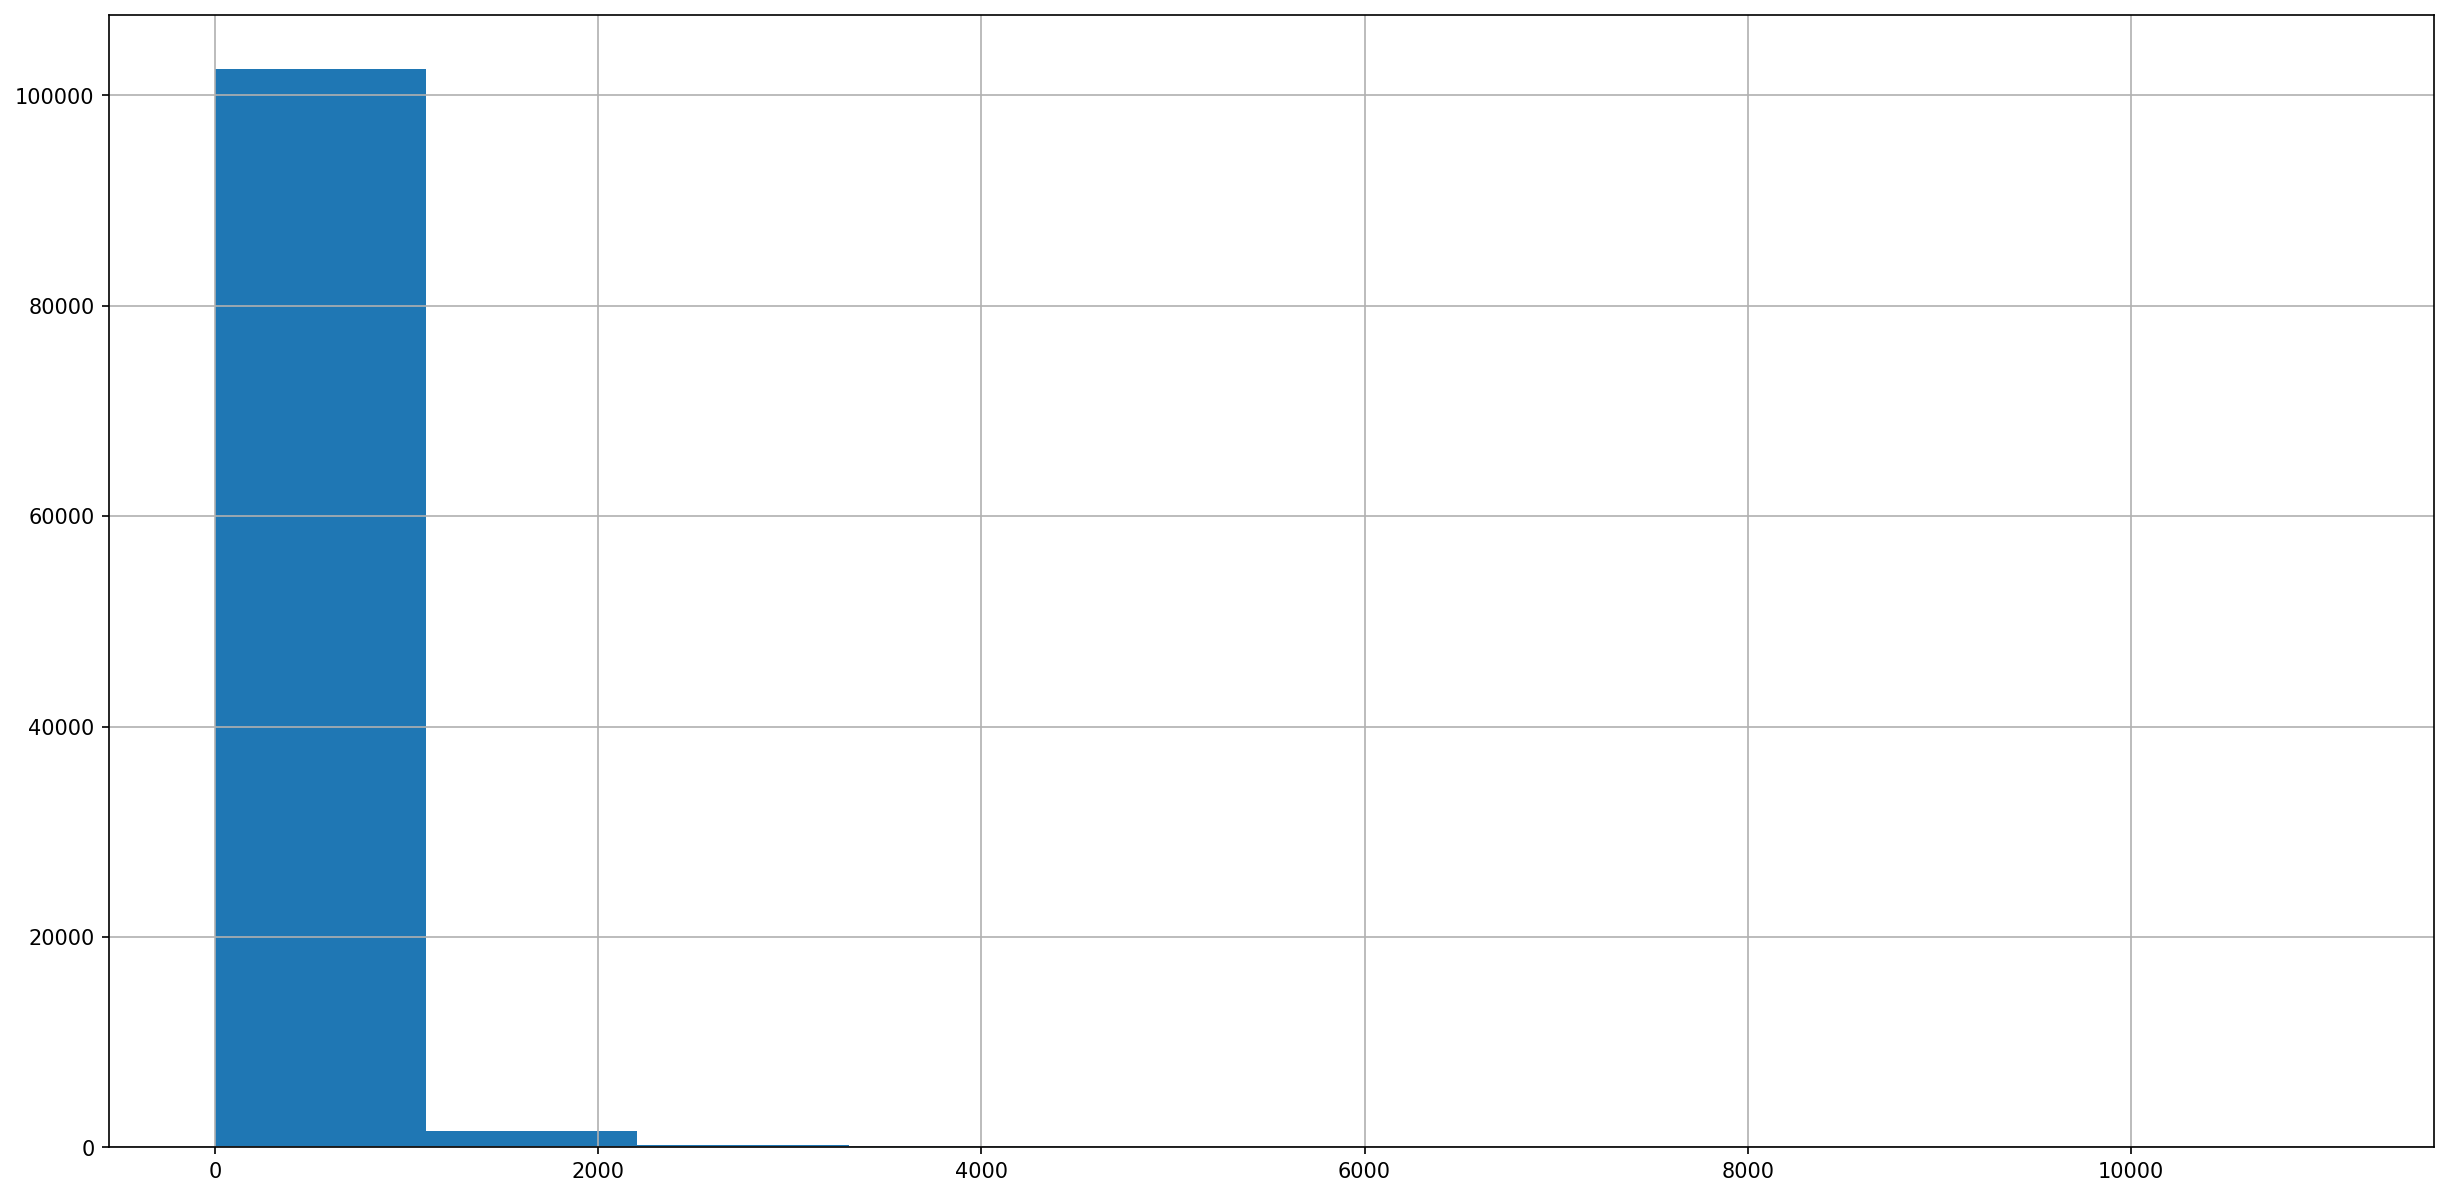

In [14]:
df.TRACK_duration.hist()

# Select two continuous attributes

In [23]:
X = df["spectral_contrastmax"].values
y = df["TRACK_duration"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

In [24]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [25]:
y_pred = reg.predict(X_test)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [8.6174175]
Intercept: 
 273.0042219883952
R2: 0.105
MSE: 68279.902
MAE: 137.466


# 2D plot

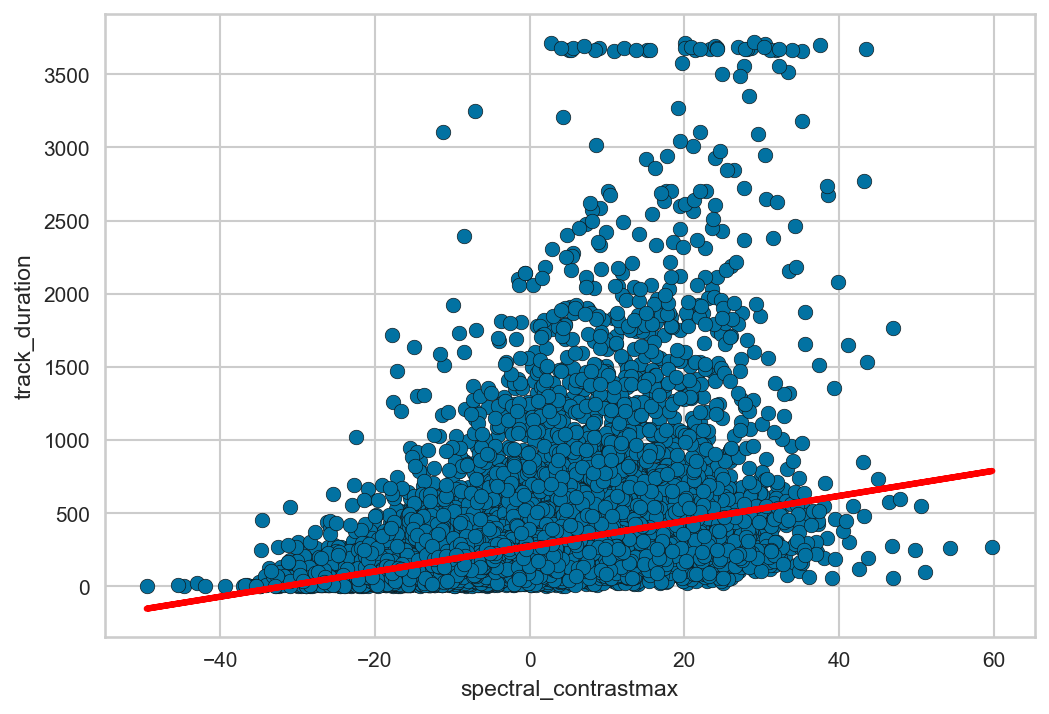

In [28]:
fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test, edgecolor='k')
ax1.plot(X_test, y_pred, color='red', linewidth=3)
ax1.set_xlabel('spectral_contrastmax')
ax1.set_ylabel('track_duration')
#plt.savefig("regression2d.pdf", bbox_inches="tight")
plt.show()

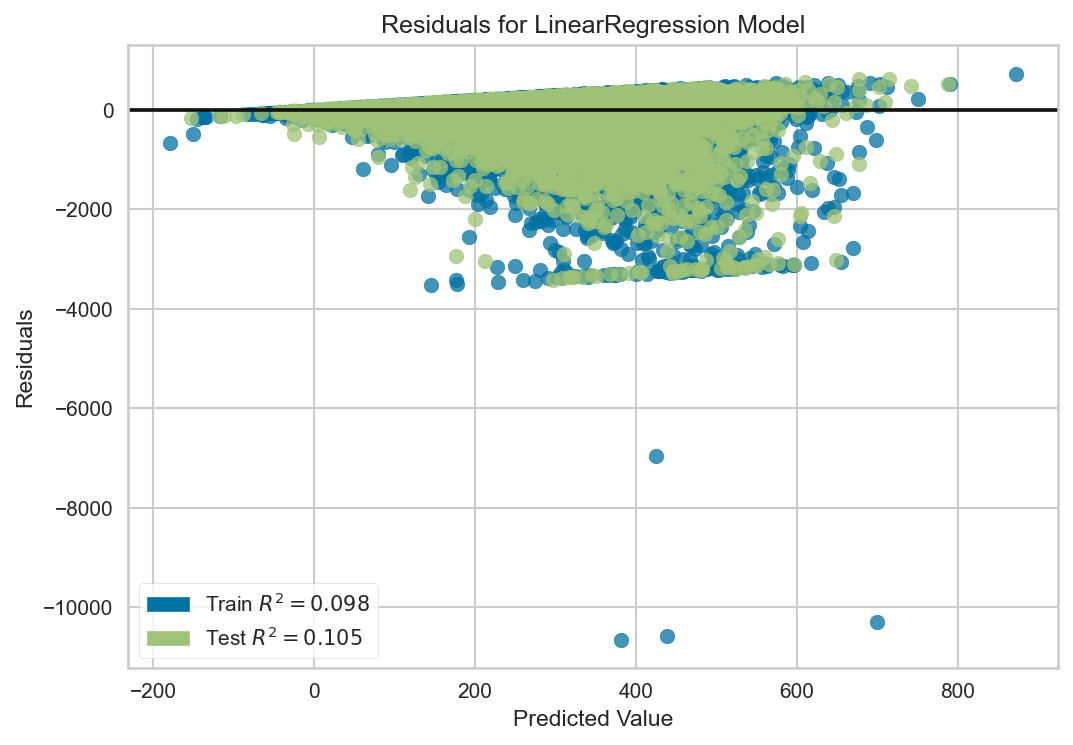

In [27]:
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()

visualizer = ResidualsPlot(model, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Lasso

In [13]:
reg = Lasso(alpha=0.0001)
reg.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [14]:
y_pred = reg.predict(X_test)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [8.61741658]
Intercept: 
 273.0042219656394
R2: 0.105
MSE: 68279.902
MAE: 137.466


# Ridge

In [15]:
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)

Ridge(alpha=1)

In [16]:
y_pred = reg.predict(X_test)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [8.61741642]
Intercept: 
 273.00422196158047
R2: 0.105
MSE: 68279.902
MAE: 137.466


# Huber

In [17]:
#Linear regression model that is robust to outliers
from sklearn.linear_model import HuberRegressor

In [18]:
reg = HuberRegressor(epsilon=2.0)
reg.fit(X_train, y_train)
outliers = reg.outliers_ * 1

In [19]:
y_pred = reg.predict(X_test)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

Coefficients: 
 [4.97747429]
Intercept: 
 237.40226964435516
R2: 0.071
MSE: 70900.765
MAE: 126.701


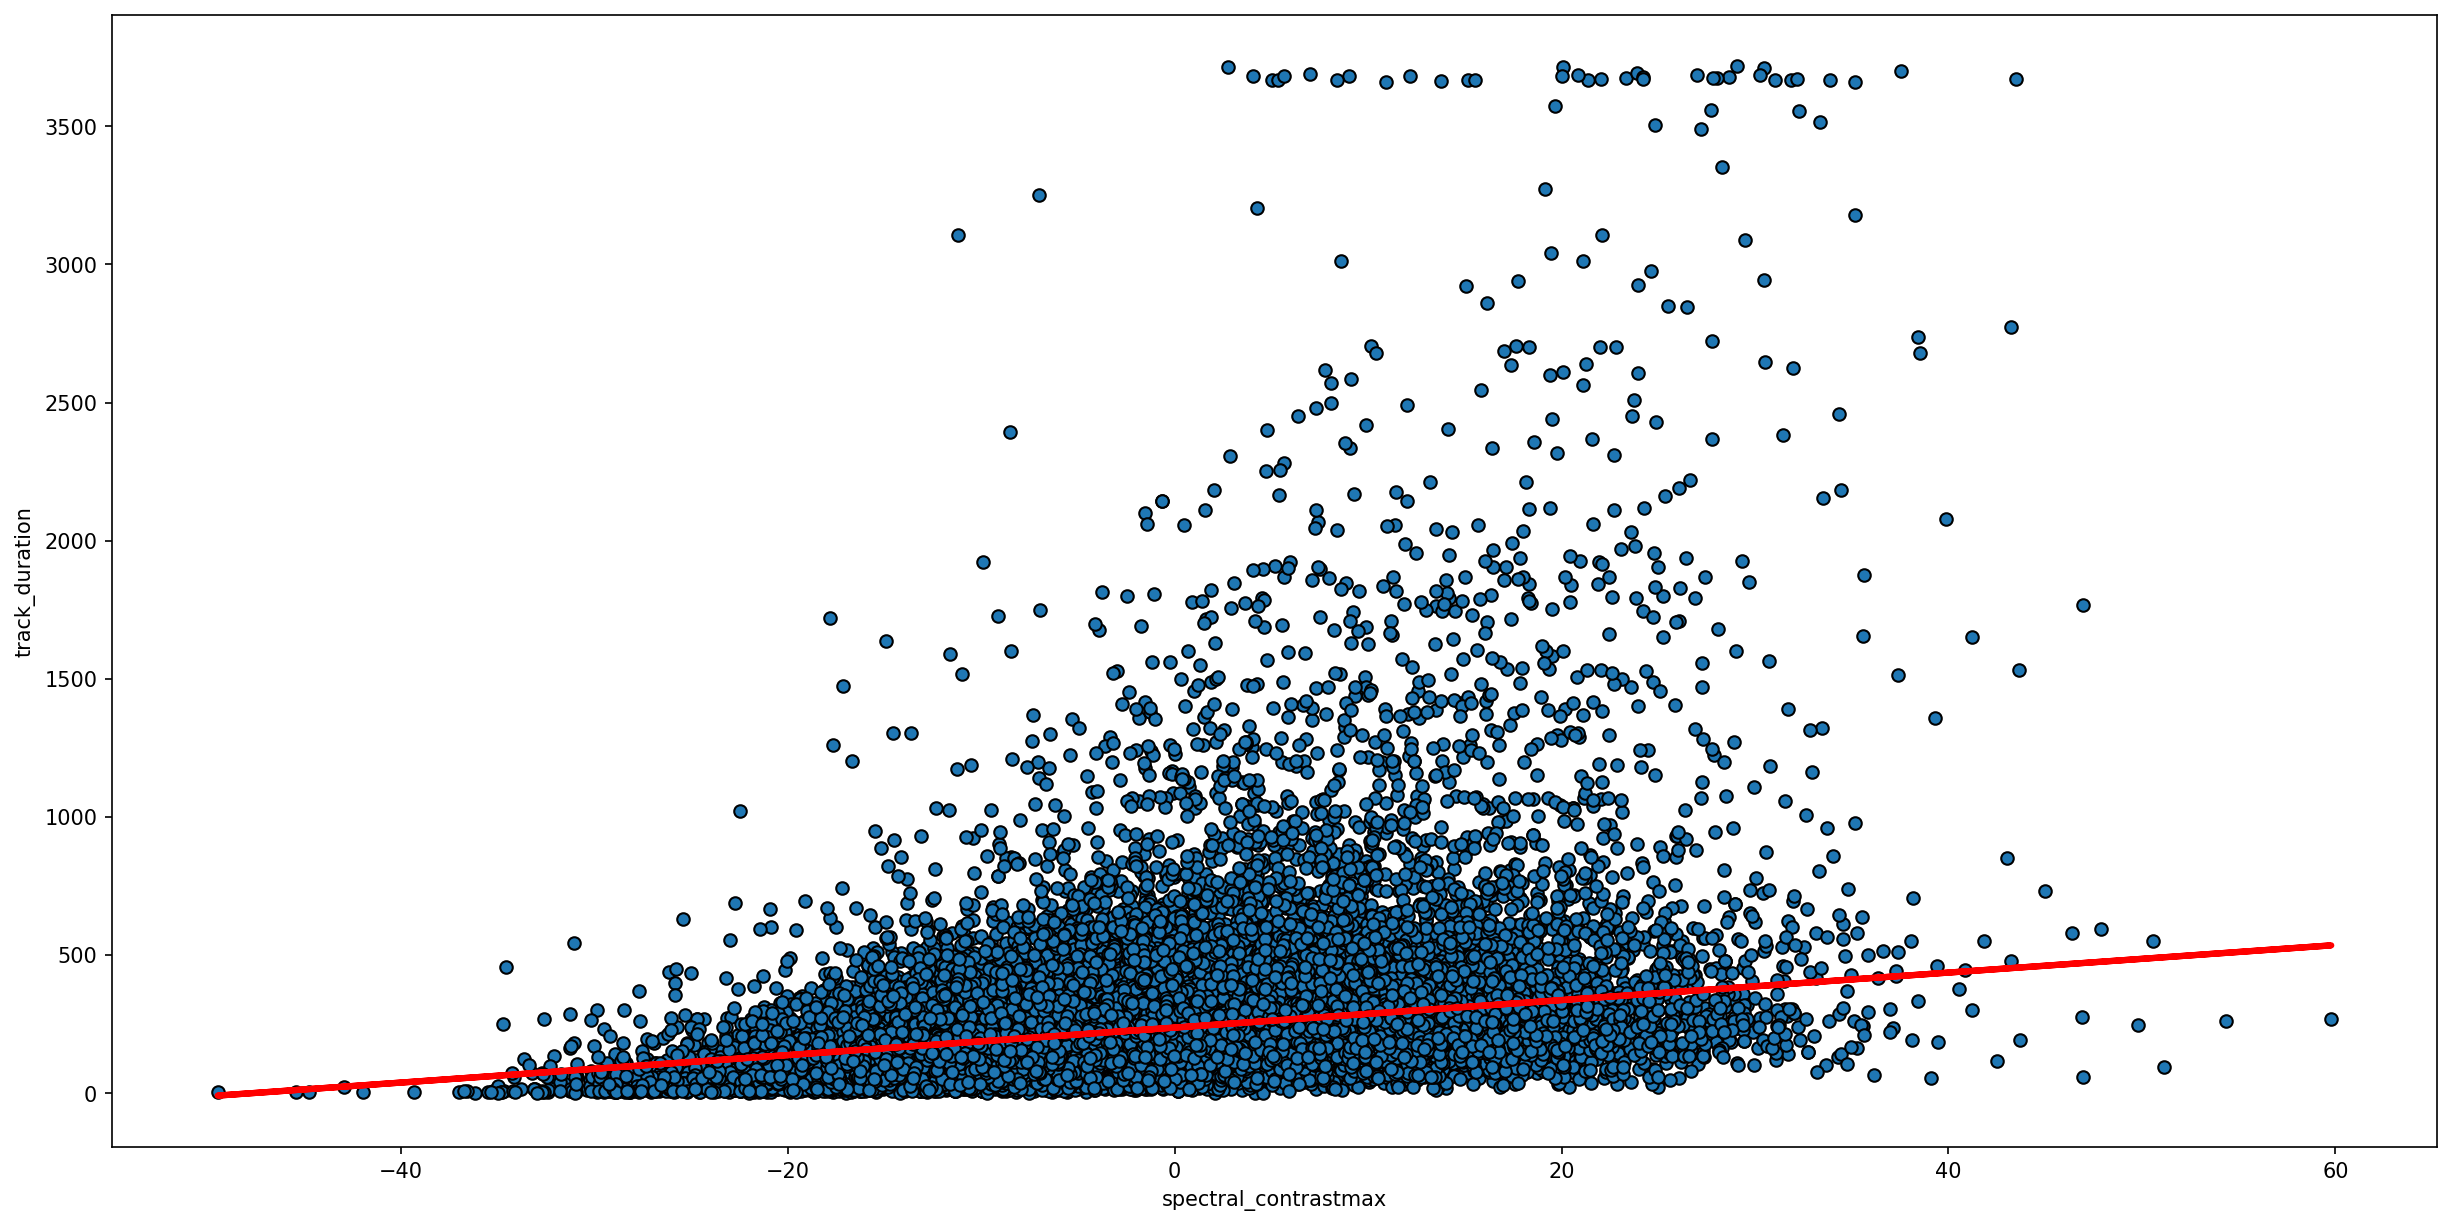

In [22]:
fig1, ax1 = plt.subplots()
ax1.scatter(X_test, y_test, edgecolor='k', label=outliers)
ax1.plot(X_test, y_pred, color='red', linewidth=3)
ax1.set_xlabel('spectral_contrastmax')
ax1.set_ylabel('track_duration')
plt.show()

# CODICE LEZIONE:

## Data Partitioning

In [82]:
corr = df[compl].corr()
corr.style.background_gradient(cmap='coolwarm')

,ALBUM_date_released_year_,ALBUM_favorites_,ALBUM_listens_,ALBUM_tracks_,ALBUM_type_,ARTIST_favorites_,TRACK_bitrate,TRACK_duration,TRACK_interest,TRACK_listens,TRACK_number
ALBUM_date_released_year_,1.000000,0.014179,0.126269,0.037136,-0.088836,0.068948,0.350858,0.013819,0.049260,0.126269,0.037136
ALBUM_favorites_,0.014179,1.000000,0.689951,-0.117479,-0.054382,0.370832,0.030397,-0.028433,0.687670,0.689951,-0.117479
ALBUM_listens_,0.126269,0.689951,1.000000,-0.150692,-0.090749,0.330990,0.042929,-0.013858,0.931207,1.000000,-0.150692
ALBUM_tracks_,0.037136,-0.117479,-0.150692,1.000000,-0.073039,-0.046590,0.044493,-0.007655,-0.159774,-0.150692,1.000000
ALBUM_type_,-0.088836,-0.054382,-0.090749,-0.073039,1.000000,-0.072095,-0.124607,0.067013,-0.096583,-0.090749,-0.073039
ARTIST_favorites_,0.068948,0.370832,0.330990,-0.046590,-0.072095,1.000000,0.069113,-0.051210,0.342898,0.330990,-0.046590
TRACK_bitrate,0.350858,0.030397,0.042929,0.044493,-0.124607,0.069113,1.000000,0.003118,0.004646,0.042929,0.044493
TRACK_duration,0.013819,-0.028433,-0.013858,-0.007655,0.067013,-0.051210,0.003118,1.000000,-0.020644,-0.013858,-0.007655
TRACK_interest,0.049260,0.687670,0.931207,-0.159774,-0.096583,0.342898,0.004646,-0.020644,1.000000,0.931207,-0.159774
TRACK_listens,0.126269,0.689951,1.000000,-0.150692,-0.090749,0.330990,0.042929,-0.013858,0.931207,1.000000,-0.150692


In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.corrwith(other=df["TRACK_duration"]).sort_values())

chroma_censmax                 -0.281663
tonnetzmin                     -0.235268
spectral_contrastmin           -0.138952
chroma_cqtmin                  -0.136705
chroma_censmin                 -0.129294
mfccskew                       -0.109305
spectral_centroidmin01         -0.088400
chroma_stftmin                 -0.086125
spectral_rolloffmin01          -0.085629
rmsemedian01                   -0.085163
rmsemean01                     -0.084401
Rock                           -0.083546
Pop                            -0.082993
spectral_bandwidthmin01        -0.071346
ARTIST_favorites               -0.070964
zcrmin01                       -0.070239
rmsestd01                      -0.067366
Hip-Hop                        -0.067142
ALBUM_listens                  -0.065132
ALBUM_favorites                -0.064627
chroma_stftstd                 -0.063498
ALBUM_tracks                   -0.057068
ARTIST_favorites_              -0.051210
mfccstd                        -0.049615
chroma_censstd  

In [134]:
class_name = 'TRACK_duration'

attributes = compl + features
#discreti da rimuovere
attributes.remove("ALBUM_type_")
attributes.remove("ALBUM_date_released_year_")
attributes.remove("TRACK_bitrate")
attributes.remove('TRACK_number')
attributes.remove('ALBUM_tracks_')
attributes.remove(class_name)


X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Linear Regression

In [135]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [136]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [137]:
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [-4.87905026e+00  7.01389136e+00 -4.52211458e-02 -7.56403501e+00
  7.01389136e+00  1.96405774e-01 -2.50746826e+02  4.85035032e+00
  2.81096901e+01  5.62484167e+02 -2.26734467e+01 -4.83665606e+02
  5.40885072e-02  1.57797019e+02 -3.04567366e+02  1.00543741e+02
 -2.07797111e+02  1.68609189e+01  7.37505375e+02  3.13468402e-01
  5.46518076e+01 -2.92801388e+01  2.75261848e+01  6.64910038e+00
  1.24745570e+00  2.27139147e+02  5.48157140e-01 -3.32904067e-01
  1.41059236e+00 -5.60517761e-01 -2.80436000e-01 -6.62288835e+00
 -8.18263554e-01 -2.22731361e+00  8.65290419e+00 -1.54015858e+01
  1.02071984e+01 -5.18862739e+00  5.76226777e+00 -2.07958135e+01
 -2.24147895e+00  6.33065042e+02  4.22185123e+01  2.67389954e+01
 -6.30134179e+02  5.61892262e+00 -2.37379484e+03  8.03553989e-01
  8.70696013e+00 -1.98774699e+01  1.30202811e+01 -9.89152085e+00
 -2.24761308e+01 -2.71465666e+01  3.44310422e-01  5.89092670e-03
 -8.64972686e-02  8.44740465e-02  4.20654038e-02  2.29850737e+00
  1.73931

In [138]:
y_pred = reg.predict(X_test)

In [140]:
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.313
MSE: 59425.740
MAE: 127.898


## Linear Regression in 2 dimensions

In [136]:
reg = LinearRegression()
reg.fit(X_train.T[1].reshape(-1, 1), y_train)
y_pred = reg.predict(X_test.T[1].reshape(-1, 1))

print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.000
MSE: 86544.758
MAE: 148.846


In [137]:
x_values = sorted([v for v in X_test.T[1]])
y_values = y_pred[np.argsort(X_test.T[1])]

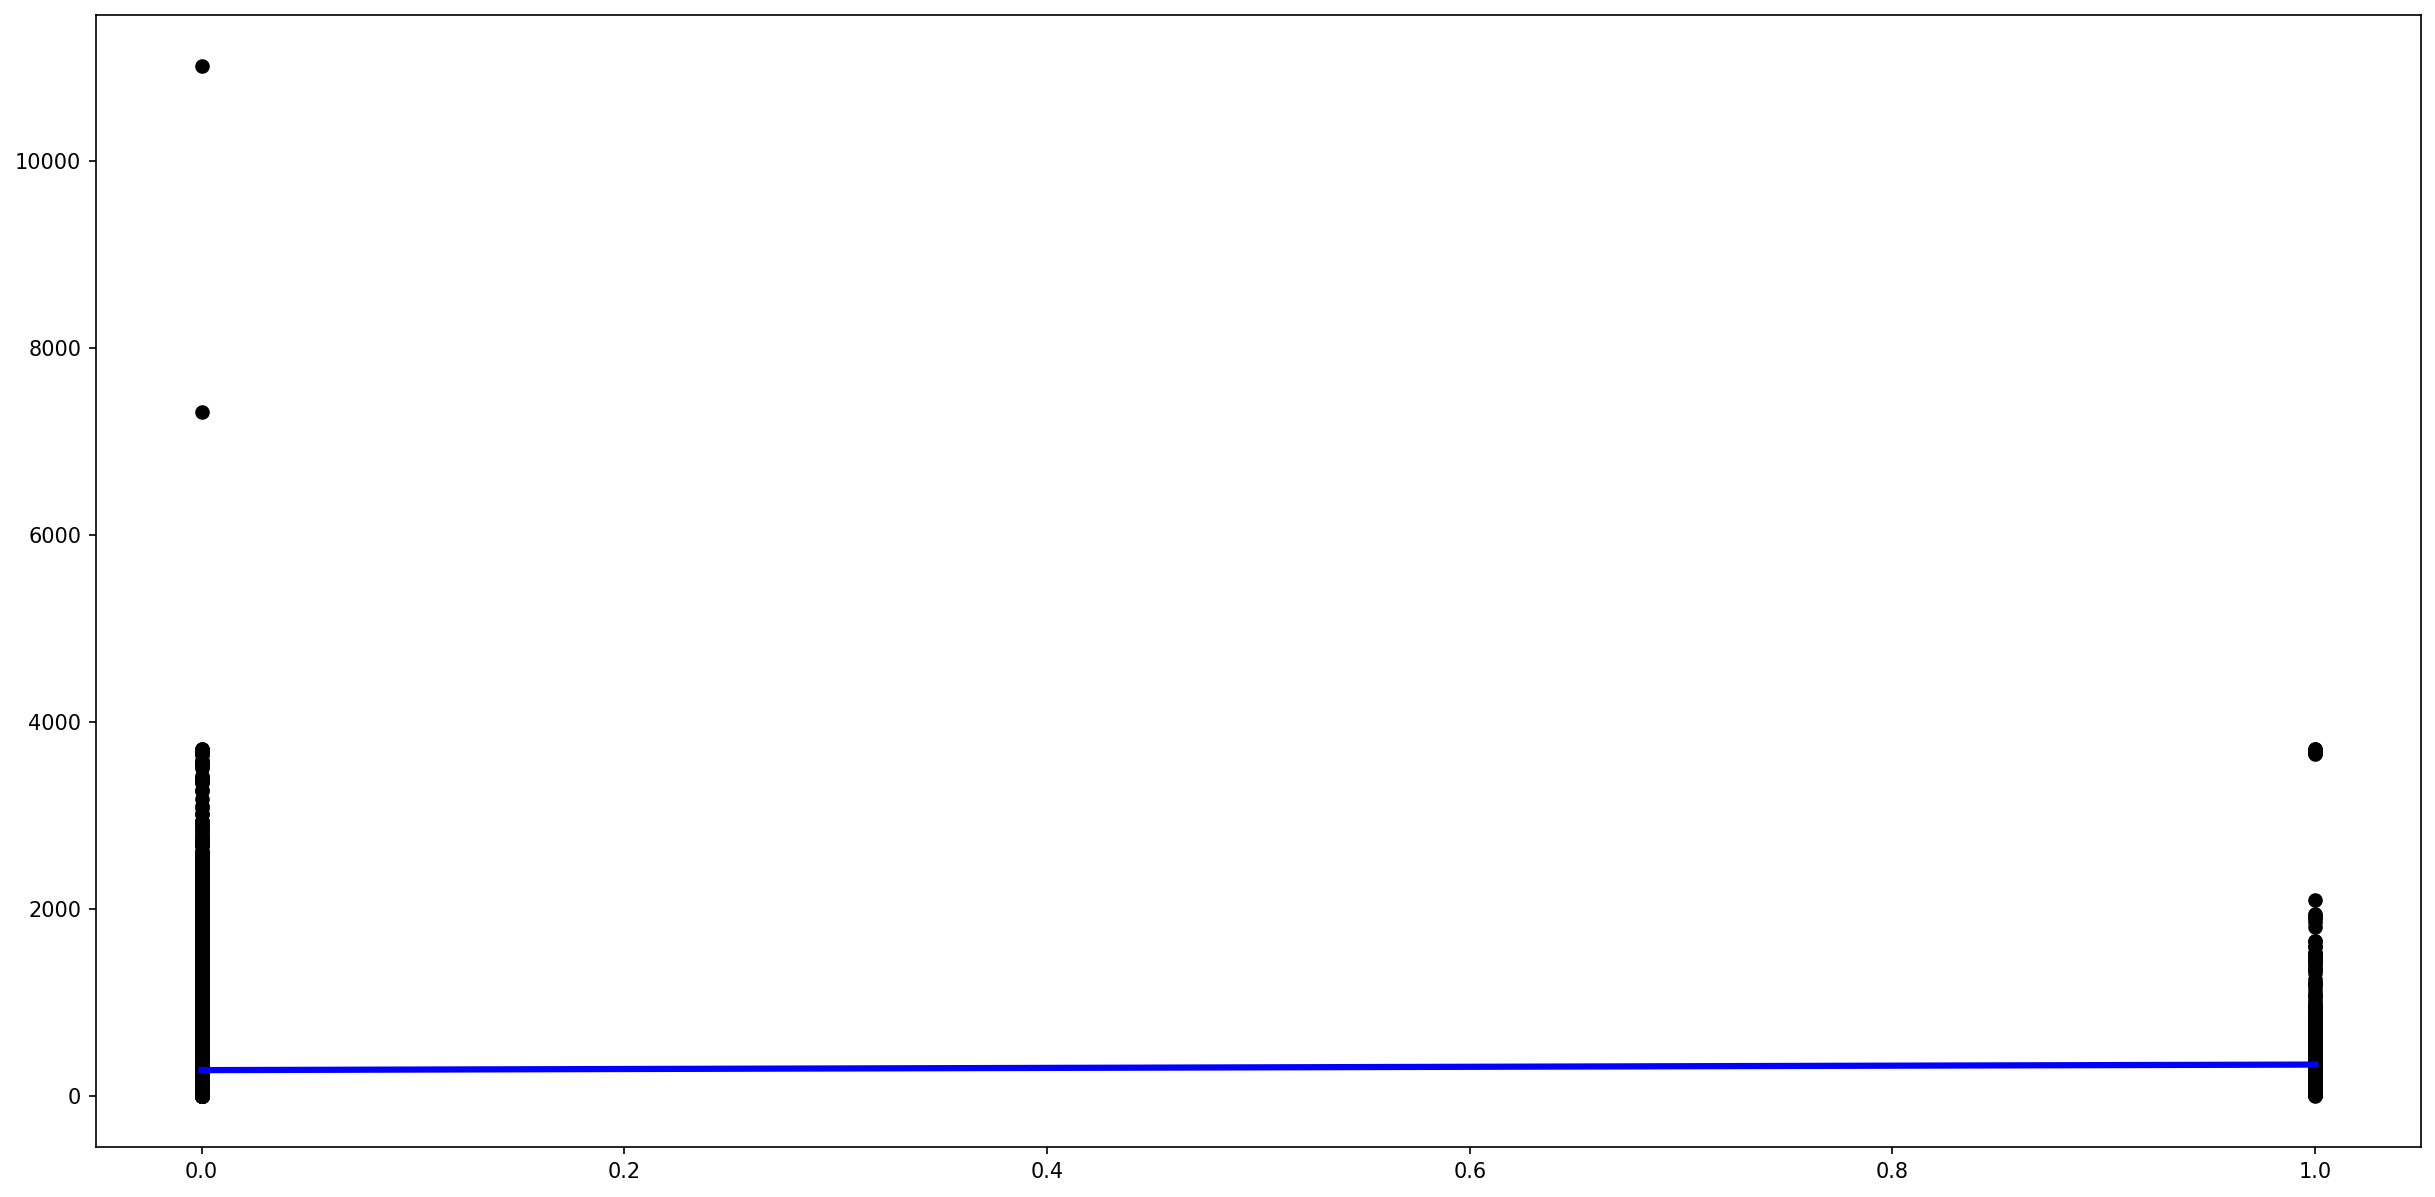

In [192]:
plt.scatter(X_test.T[1], y_test,  color='black')
plt.plot(x_values, y_values, color='blue', linewidth=3)
plt.show()

# Lasso

In [141]:
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [-4.60598630e+00  3.65183909e+00 -9.29348208e-02 -0.00000000e+00
  2.19624340e+00  1.16106452e-01 -2.85862025e+02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.27419957e+00  0.00000000e+00
  7.08140379e-03  0.00000000e+00 -5.29685225e+01 -7.75542238e+01
  0.00000000e+00  0.00000000e+00  4.89397521e+02  6.49667168e-01
  0.00000000e+00 -0.00000000e+00  6.93015669e+01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  5.44499224e-01 -4.61118114e-01
  1.71198826e+00 -8.05361333e-01 -2.71778872e-01 -2.03203946e+00
 -8.73174297e-01 -2.86191380e+00  1.01923230e+01 -1.75619050e+01
  1.13629108e+01 -5.98238751e+00  7.68955954e+00 -2.42795137e+01
 -5.70962489e-01  1.69900315e+02  0.00000000e+00  0.00000000e+00
 -1.57303603e+02  3.95333803e-01 -0.00000000e+00  7.98965418e-01
  9.23723423e+00 -6.40144143e+00  1.37297064e+00 -0.00000000e+00
 -1.94072575e+01 -3.73803267e+01  4.15509337e-01  3.01513636e-02
 -9.28189886e-02  9.06224571e-02  4.48273068e-02  1.90514258e+00
  1.93844

C:\Users\falle\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045839865.8466799, tolerance: 705584.0090109119
  model = cd_fast.enet_coordinate_descent(


In [142]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.270
MSE: 63191.679
MAE: 128.222


# Ridge

In [143]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [-5.01533470e+00  6.95304802e+00 -4.60105324e-02 -7.42444276e+00
  6.95304802e+00  1.95695509e-01 -2.61322305e+02  3.40447042e+00
  2.81943576e+01  5.50032931e+02 -2.25196630e+01 -4.19649209e+02
  5.40556832e-02  1.59729478e+02 -2.98950283e+02  9.74670253e+01
 -2.04113977e+02  1.67783529e+01  7.19021265e+02  3.41221238e-01
  4.70024745e+01 -2.73213458e+01  2.75054475e+01  6.53061018e+00
  7.01296478e-01  2.28433595e+02  5.52506440e-01 -3.37650132e-01
  1.42252051e+00 -5.66678420e-01 -2.79647465e-01 -6.59508424e+00
 -8.22786429e-01 -2.25043160e+00  8.67680283e+00 -1.56013071e+01
  1.03611105e+01 -5.24465008e+00  5.76469810e+00 -2.07345443e+01
 -2.18916910e+00  6.16602738e+02  3.84315963e+01  2.34872349e+01
 -6.12722921e+02  5.58231756e+00 -2.23506467e+03  8.04924843e-01
  8.78828244e+00 -1.97590240e+01  1.28883733e+01 -9.94857557e+00
 -2.25571216e+01 -2.75869804e+01  3.43142949e-01  6.38345719e-03
 -9.96977182e-02  9.26660263e-02  4.56058931e-02  2.47057582e+00
  1.83526

In [144]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.313
MSE: 59499.574
MAE: 127.748


In [189]:
#Per trovare parametro alpha
parameters=range(0, 100, 1)
res = list()

for a in parameters:
    reg = Ridge(alpha=a/100)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    res.append([a, reg.intercept_, r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)])

result = pd.DataFrame(res, columns=['alpha', 'intercept', 'r2', 'mse', 'mae'])

In [190]:
result

,alpha,intercept,r2,mse,mae
0,0,-3109.777689,0.326313,58305.137134,127.198509
1,1,-3108.543869,0.326308,58305.570533,127.196426
2,2,-3107.509037,0.326301,58306.143647,127.194306
3,3,-3106.509680,0.326294,58306.716614,127.192216
4,4,-3105.543940,0.326288,58307.288674,127.190180
...,...,...,...,...,...
95,95,-3070.420921,0.325854,58344.872502,127.057643
96,96,-3070.255652,0.325850,58345.181377,127.056404
97,97,-3070.092227,0.325846,58345.489193,127.055169
98,98,-3069.930610,0.325843,58345.795974,127.053940


In [165]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.323
MSE: 58591.419
MAE: 126.587


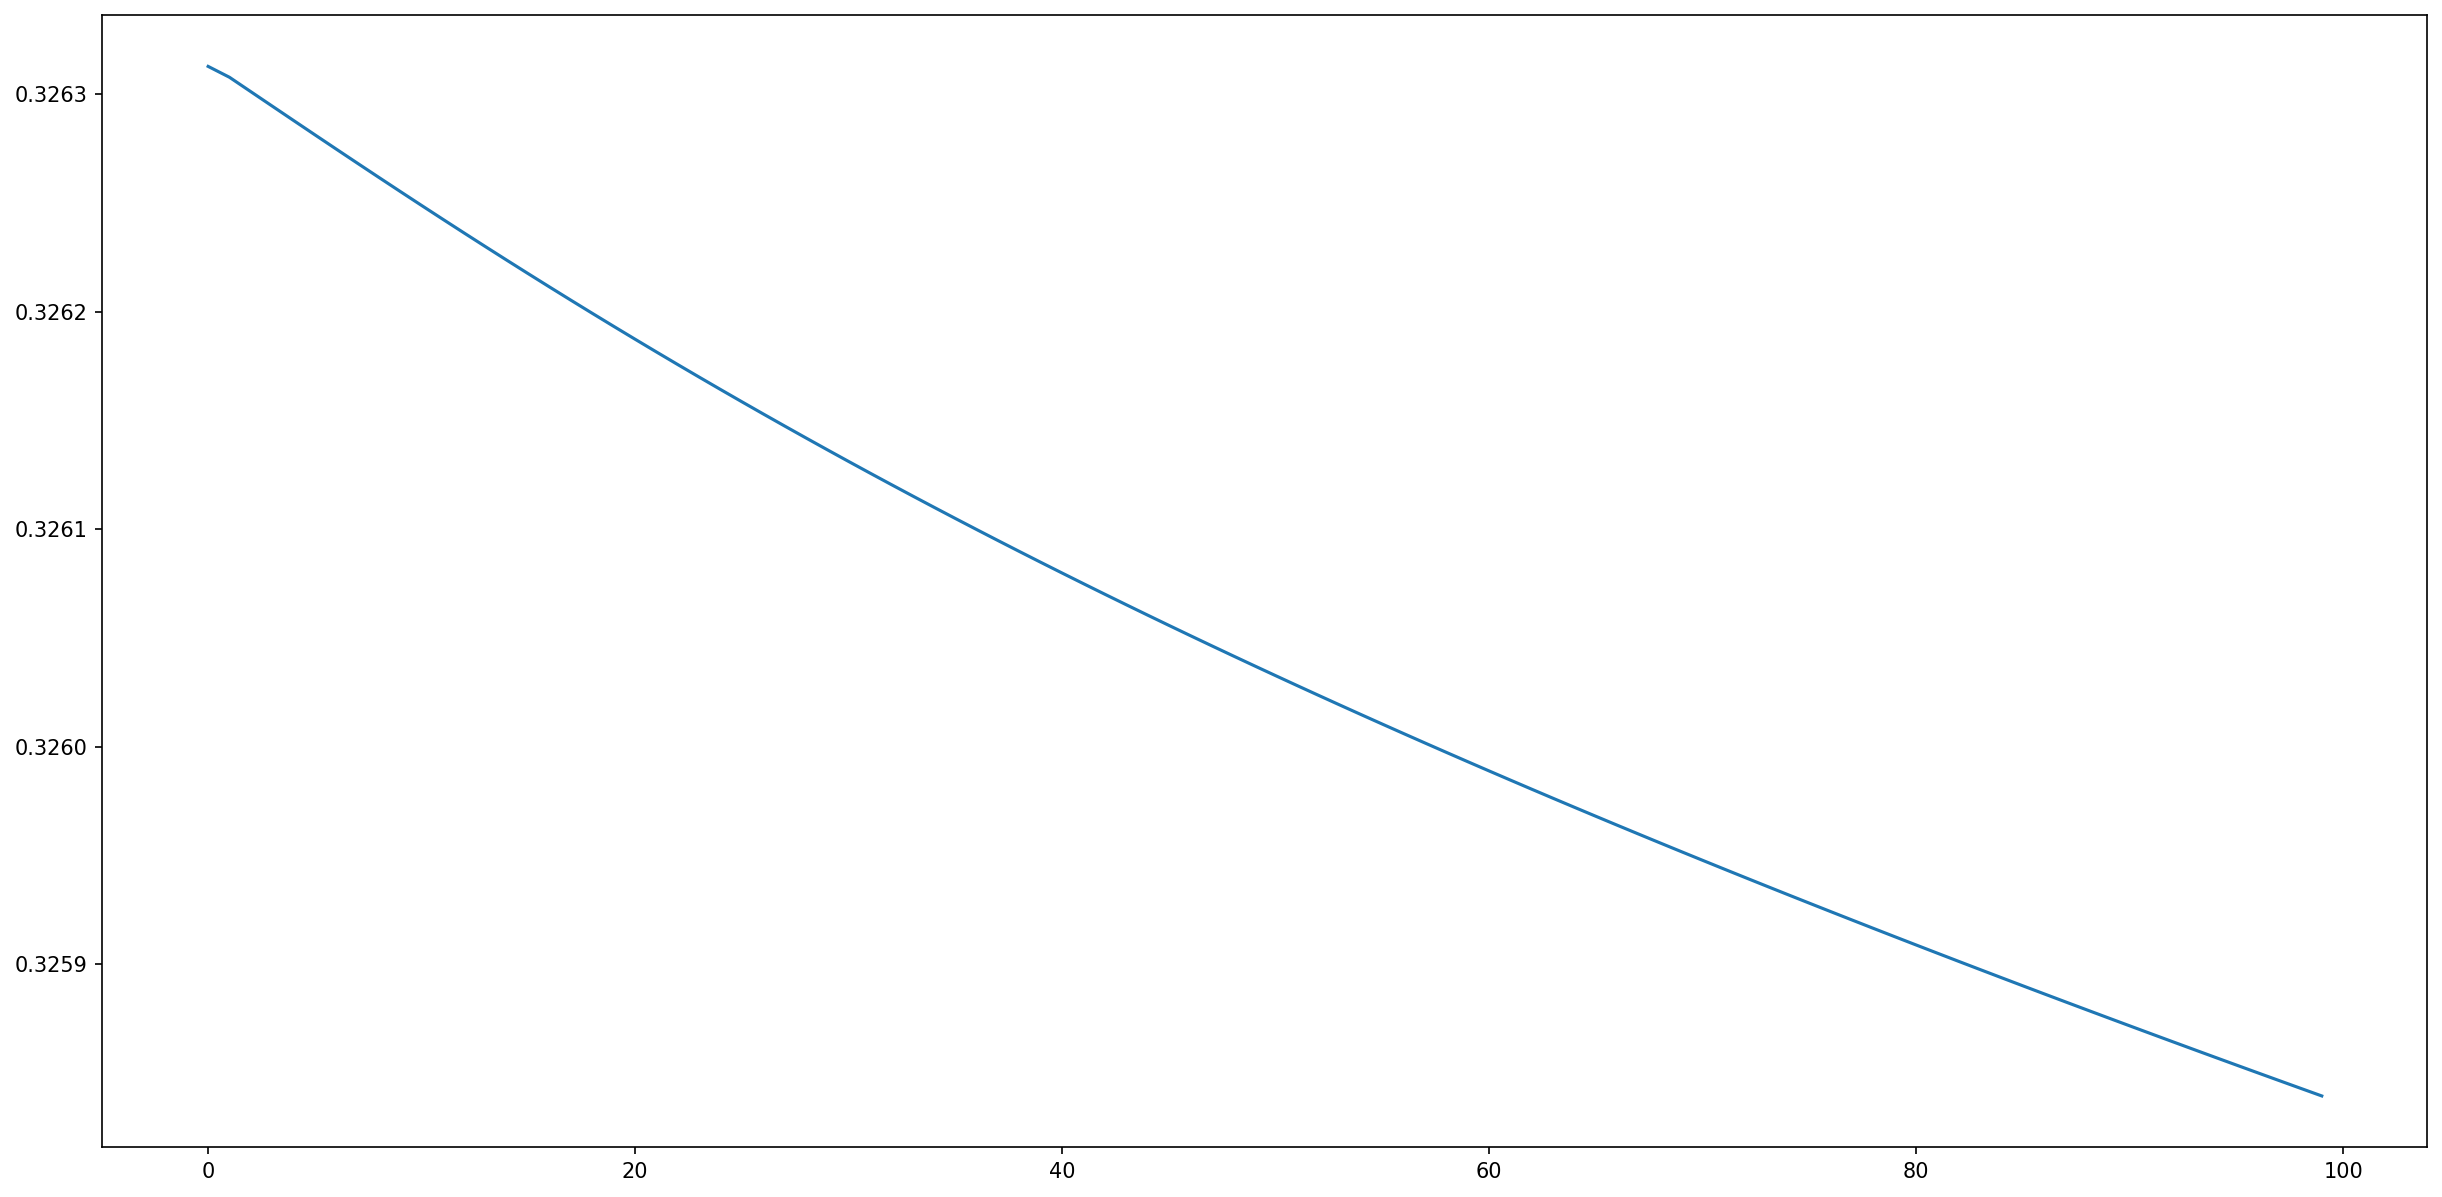

In [191]:
result['r2'].plot.line()